In [ ]:
!pip install celldisect
!pip install torchvision==0.16.2
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%load_ext autoreload
%autoreload 2

from celldisect import CellDISECT
import scvi
scvi.settings.seed = 42
import scanpy as sc
from anndata import AnnData
import os
import shutil
import gc
import anndata as ad
import pandas as pd
from scipy.stats import pearsonr
import numpy as np


INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [3]:
# import gdown
# gdown.download('https://drive.google.com/uc?export=download&id=1z8gGKQ6oDoi2blCU2IVihKA38h5fORRp')
data_path = 'kang_normalized_hvg.h5ad'
adata = sc.read(data_path)

In [3]:
adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov'
    layers: 'counts'

In [4]:
adata.X.min(), adata.X.max()

(0.0, 9.887986)

In [5]:
adata.X = adata.layers['counts'].copy()
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [6]:
# Normalizing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

2024-11-22 16:01:18.343773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 16:01:18.361224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 16:01:18.366851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 16:01:19.321365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

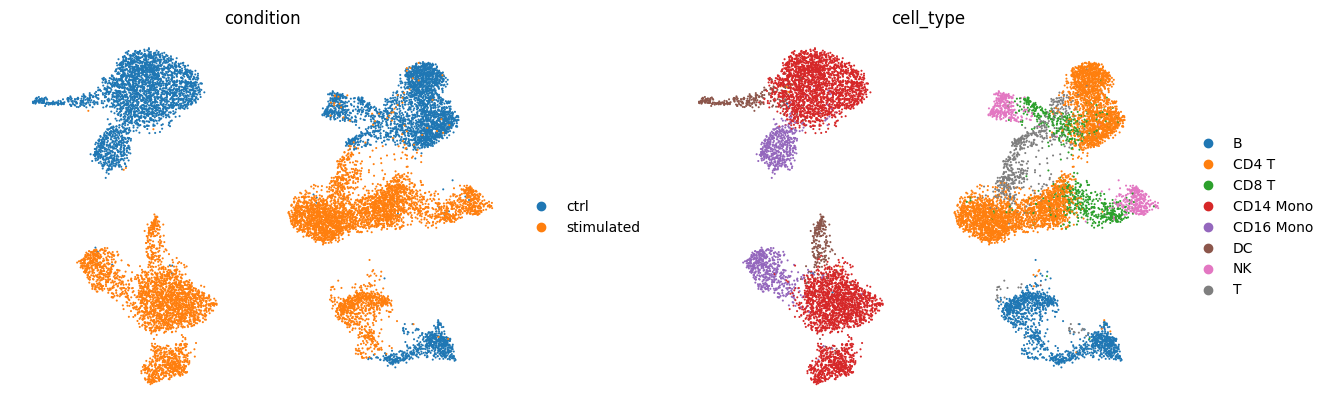

In [8]:
sc.pl.umap(
    adata,
    color=['condition', 'cell_type'],
    frameon=False,
    # legend_loc=None,
    wspace=0.2,
    )

In [4]:
cats = ['cell_type', 'condition']

In [5]:
adata.X = adata.layers['counts'].copy()
adata = adata[adata.X.sum(1) != 0].copy()
adata.X.min(), adata.X.max()

(0.0, 3828.0)

In [6]:
cell_type_included = True # Set to True if you have provided a cell type annotation in the cats list

module_name = 'Kang'
pre_path = f'drive/MyDrive/cellDISECT/models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

arch_dict = {'n_layers': 2,
 'n_hidden': 128,
 'n_latent_shared': 32,
 'n_latent_attribute': 32,
 'dropout_rate': 0.1,
 'weighted_classifier': True,
}
train_dict = {
 'max_epochs': 1000,
 'batch_size': 256,
 'recon_weight': 20,
 'cf_weight': 0.8,
 'beta': 0.003,
 'clf_weight': 0.05,
 'adv_clf_weight': 0.014,
 'adv_period': 5,
 'n_cf': 1,
 'early_stopping_patience': 6,
 'early_stopping': True,
 'save_best': True,
 'kappa_optimizer2': False,
 'n_epochs_pretrain_ae': 0,
}

plan_kwargs = {
 'lr': 0.003,
 'weight_decay': 0.00005,
 'ensemble_method_cf': True,
 'lr_patience': 5,
 'lr_factor': 0.5,
 'lr_scheduler_metric': 'loss_validation',
 'n_epochs_kl_warmup': 10,
}

# specify a name for your model
model_name = (
    f'pretrainAE_{train_dict["n_epochs_pretrain_ae"]}_'
    f'maxEpochs_{train_dict["max_epochs"]}_'
    f'reconW_{train_dict["recon_weight"]}_'
    f'cfWeight_{train_dict["cf_weight"]}_'
    f'beta_{train_dict["beta"]}_'
    f'clf_{train_dict["clf_weight"]}_'
    f'adv_{train_dict["adv_clf_weight"]}_'
    f'advp_{train_dict["adv_period"]}_'
    f'n_cf_{train_dict["n_cf"]}_'
    f'lr_{plan_kwargs["lr"]}_'
    f'wd_{plan_kwargs["weight_decay"]}_'
    f'ensemble_cf_{plan_kwargs["ensemble_method_cf"]}_'
    f'dropout_{arch_dict["dropout_rate"]}_'
    f'n_hidden_{arch_dict["n_hidden"]}_'
    f'n_latent_{arch_dict["n_latent_shared"]}_'
    f'n_layers_{arch_dict["n_layers"]}_'
    f'batch_size_{train_dict["batch_size"]}_'
    f'weighted_classifier_{arch_dict["weighted_classifier"]}_'
)
if cell_type_included:
    model_name = model_name + f'cellTypeIncluded'
else:
    model_name = model_name + f'cellTypeNotIncluded'

try: # Clean up the directory if it exists, overwrite the model | THIS WILL DELTE THE MODEL IF ALREADY EXISTS
    shutil.rmtree(f"{pre_path}/{model_name}")
    print("Directory deleted successfully")
except OSError as e:
    print(f"Error deleting directory: {e}")

Directory deleted successfully


In [12]:
CellDISECT.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[],
    add_cluster_covariate=not cell_type_included, # add_cluster_covariate if cell type is not included
)

In [13]:
adata.obs['split_CD14 Mono'].value_counts()

split_CD14 Mono
train    10285
ood       2147
valid     1144
Name: count, dtype: int64

In [14]:
## Use this to make random splits
# model = CellDISECT(adata,
#                    **arch_dict)
# Use this if you have pre-defined splits
split_key = 'split_CD14 Mono'
model = CellDISECT(adata,
                    split_key=split_key,
                    train_split=['train'],
                    valid_split=['valid'],
                    test_split=['ood'],
                    **arch_dict)

model.train(**train_dict, plan_kwargs=plan_kwargs, )
model.save(f"{pre_path}/{model_name}", overwrite=True)
print(model_name)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/1000:   0%|          | 1/1000 [00:06<1:40:06,  6.01s/it, v_num=1, loss_validation=5.55, x_0_validation=0.265, x_1_validation=0.28, x_2_validation=0.267, rec_x_cf_validation=0.094, z_1_validation=1.69, z_2_validation=1.92, ce_validation=1.41, acc_validation=0.395, f1_validation=0.395, adv_ce_validation=1.4, adv_acc_validation=0.378, adv_f1_validation=0.378, loss_train=5.69, x_0_train=0.279, x_1_train=0.276, x_2_train=0.278, rec_x_cf_train=0.0925, z_1_train=16.1, z_2_train=14.3, ce_train=1.38, acc_train=0.44, f1_train=0.44, adv_ce_train=1.48, adv_acc_train=0.381, adv_f1_train=0.381]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00001: loss_validation reached. Module best state updated.


Epoch 3/1000:   0%|          | 2/1000 [00:09<1:12:07,  4.34s/it, v_num=1, loss_validation=5.23, x_0_validation=0.251, x_1_validation=0.258, x_2_validation=0.253, rec_x_cf_validation=0.0942, z_1_validation=3.52, z_2_validation=3.65, ce_validation=1.35, acc_validation=0.449, f1_validation=0.449, adv_ce_validation=1.25, adv_acc_validation=0.439, adv_f1_validation=0.439, loss_train=4.92, x_0_train=0.24, x_1_train=0.238, x_2_train=0.24, rec_x_cf_train=0.0893, z_1_train=19.2, z_2_train=16.6, ce_train=1.18, acc_train=0.545, f1_train=0.545, adv_ce_train=1.19, adv_acc_train=0.507, adv_f1_train=0.507]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00002: loss_validation reached. Module best state updated.


Epoch 4/1000:   0%|          | 3/1000 [00:12<1:04:17,  3.87s/it, v_num=1, loss_validation=5.04, x_0_validation=0.244, x_1_validation=0.246, x_2_validation=0.245, rec_x_cf_validation=0.0927, z_1_validation=6.17, z_2_validation=6.03, ce_validation=1.28, acc_validation=0.498, f1_validation=0.498, adv_ce_validation=1.08, adv_acc_validation=0.552, adv_f1_validation=0.552, loss_train=4.93, x_0_train=0.24, x_1_train=0.238, x_2_train=0.24, rec_x_cf_train=0.0892, z_1_train=19.2, z_2_train=16.6, ce_train=1.18, acc_train=0.551, f1_train=0.551, adv_ce_train=1.04, adv_acc_train=0.594, adv_f1_train=0.594]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00003: loss_validation reached. Module best state updated.


Epoch 5/1000:   0%|          | 4/1000 [00:16<1:05:00,  3.92s/it, v_num=1, loss_validation=4.96, x_0_validation=0.241, x_1_validation=0.241, x_2_validation=0.241, rec_x_cf_validation=0.0921, z_1_validation=8.86, z_2_validation=8.22, ce_validation=1.22, acc_validation=0.515, f1_validation=0.515, adv_ce_validation=0.966, adv_acc_validation=0.622, adv_f1_validation=0.622, loss_train=4.93, x_0_train=0.24, x_1_train=0.238, x_2_train=0.24, rec_x_cf_train=0.0893, z_1_train=19.2, z_2_train=16.5, ce_train=1.18, acc_train=0.55, f1_train=0.55, adv_ce_train=0.959, adv_acc_train=0.639, adv_f1_train=0.639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00004: loss_validation reached. Module best state updated.


Epoch 6/1000:   0%|          | 5/1000 [00:20<1:03:16,  3.82s/it, v_num=1, loss_validation=4.93, x_0_validation=0.239, x_1_validation=0.238, x_2_validation=0.24, rec_x_cf_validation=0.0912, z_1_validation=11.1, z_2_validation=9.98, ce_validation=1.18, acc_validation=0.548, f1_validation=0.548, adv_ce_validation=0.88, adv_acc_validation=0.67, adv_f1_validation=0.67, loss_train=4.94, x_0_train=0.24, x_1_train=0.238, x_2_train=0.24, rec_x_cf_train=0.0894, z_1_train=19.2, z_2_train=16.6, ce_train=1.18, acc_train=0.549, f1_train=0.549, adv_ce_train=0.899, adv_acc_train=0.667, adv_f1_train=0.667]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00005: loss_validation reached. Module best state updated.


Epoch 7/1000:   1%|          | 6/1000 [00:26<1:15:51,  4.58s/it, v_num=1, loss_validation=4.38, x_0_validation=0.212, x_1_validation=0.212, x_2_validation=0.213, rec_x_cf_validation=0.0876, z_1_validation=8.98, z_2_validation=8.1, ce_validation=0.881, acc_validation=0.697, f1_validation=0.697, adv_ce_validation=0.77, adv_acc_validation=0.721, adv_f1_validation=0.721, loss_train=4.65, x_0_train=0.226, x_1_train=0.225, x_2_train=0.226, rec_x_cf_train=0.0881, z_1_train=15.8, z_2_train=13.9, ce_train=1.02, acc_train=0.627, f1_train=0.627, adv_ce_train=0.833, adv_acc_train=0.693, adv_f1_train=0.693]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00006: loss_validation reached. Module best state updated.


Epoch 11/1000:   1%|          | 10/1000 [00:40<1:00:50,  3.69s/it, v_num=1, loss_validation=4.39, x_0_validation=0.212, x_1_validation=0.212, x_2_validation=0.213, rec_x_cf_validation=0.0874, z_1_validation=10.1, z_2_validation=9.07, ce_validation=0.826, acc_validation=0.724, f1_validation=0.724, adv_ce_validation=0.613, adv_acc_validation=0.775, adv_f1_validation=0.775, loss_train=4.43, x_0_train=0.214, x_1_train=0.214, x_2_train=0.215, rec_x_cf_train=0.086, z_1_train=12.6, z_2_train=11.4, ce_train=0.858, acc_train=0.706, f1_train=0.706, adv_ce_train=0.679, adv_acc_train=0.748, adv_f1_train=0.748]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00010: loss_validation reached. Module best state updated.


Epoch 12/1000:   1%|          | 11/1000 [00:47<1:14:41,  4.53s/it, v_num=1, loss_validation=4.15, x_0_validation=0.201, x_1_validation=0.202, x_2_validation=0.202, rec_x_cf_validation=0.086, z_1_validation=6.46, z_2_validation=5.75, ce_validation=0.618, acc_validation=0.805, f1_validation=0.805, adv_ce_validation=0.66, adv_acc_validation=0.723, adv_f1_validation=0.723, loss_train=4.29, x_0_train=0.208, x_1_train=0.208, x_2_train=0.209, rec_x_cf_train=0.0848, z_1_train=10.5, z_2_train=9.32, ce_train=0.746, acc_train=0.758, f1_train=0.758, adv_ce_train=0.679, adv_acc_train=0.732, adv_f1_train=0.732]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00011: loss_validation reached. Module best state updated.


Epoch 13/1000:   1%|          | 12/1000 [00:50<1:08:35,  4.17s/it, v_num=1, loss_validation=4.15, x_0_validation=0.201, x_1_validation=0.202, x_2_validation=0.201, rec_x_cf_validation=0.0865, z_1_validation=6.64, z_2_validation=5.72, ce_validation=0.612, acc_validation=0.804, f1_validation=0.804, adv_ce_validation=0.634, adv_acc_validation=0.722, adv_f1_validation=0.722, loss_train=4.18, x_0_train=0.203, x_1_train=0.203, x_2_train=0.203, rec_x_cf_train=0.0833, z_1_train=8.79, z_2_train=7.74, ce_train=0.635, acc_train=0.801, f1_train=0.801, adv_ce_train=0.699, adv_acc_train=0.71, adv_f1_train=0.71]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00012: loss_validation reached. Module best state updated.


Epoch 14/1000:   1%|▏         | 13/1000 [00:53<1:03:58,  3.89s/it, v_num=1, loss_validation=4.15, x_0_validation=0.201, x_1_validation=0.202, x_2_validation=0.202, rec_x_cf_validation=0.086, z_1_validation=6.7, z_2_validation=5.7, ce_validation=0.604, acc_validation=0.817, f1_validation=0.817, adv_ce_validation=0.617, adv_acc_validation=0.738, adv_f1_validation=0.738, loss_train=4.18, x_0_train=0.203, x_1_train=0.203, x_2_train=0.203, rec_x_cf_train=0.0835, z_1_train=8.79, z_2_train=7.72, ce_train=0.637, acc_train=0.802, f1_train=0.802, adv_ce_train=0.679, adv_acc_train=0.716, adv_f1_train=0.716]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00013: loss_validation reached. Module best state updated.


Epoch 15/1000:   1%|▏         | 14/1000 [00:57<1:02:13,  3.79s/it, v_num=1, loss_validation=4.15, x_0_validation=0.201, x_1_validation=0.202, x_2_validation=0.202, rec_x_cf_validation=0.0857, z_1_validation=6.75, z_2_validation=5.69, ce_validation=0.606, acc_validation=0.816, f1_validation=0.816, adv_ce_validation=0.615, adv_acc_validation=0.733, adv_f1_validation=0.733, loss_train=4.18, x_0_train=0.203, x_1_train=0.203, x_2_train=0.203, rec_x_cf_train=0.0836, z_1_train=8.8, z_2_train=7.74, ce_train=0.636, acc_train=0.8, f1_train=0.8, adv_ce_train=0.663, adv_acc_train=0.717, adv_f1_train=0.717]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00014: loss_validation reached. Module best state updated.


Epoch 16/1000:   2%|▏         | 15/1000 [01:01<1:05:30,  3.99s/it, v_num=1, loss_validation=4.14, x_0_validation=0.201, x_1_validation=0.202, x_2_validation=0.201, rec_x_cf_validation=0.0855, z_1_validation=6.78, z_2_validation=5.67, ce_validation=0.594, acc_validation=0.819, f1_validation=0.819, adv_ce_validation=0.592, adv_acc_validation=0.746, adv_f1_validation=0.746, loss_train=4.18, x_0_train=0.203, x_1_train=0.203, x_2_train=0.203, rec_x_cf_train=0.0835, z_1_train=8.79, z_2_train=7.71, ce_train=0.635, acc_train=0.803, f1_train=0.803, adv_ce_train=0.646, adv_acc_train=0.724, adv_f1_train=0.724]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00015: loss_validation reached. Module best state updated.


Epoch 17/1000:   2%|▏         | 16/1000 [01:06<1:09:21,  4.23s/it, v_num=1, loss_validation=4, x_0_validation=0.194, x_1_validation=0.195, x_2_validation=0.195, rec_x_cf_validation=0.0824, z_1_validation=5.96, z_2_validation=5.11, ce_validation=0.429, acc_validation=0.889, f1_validation=0.889, adv_ce_validation=0.653, adv_acc_validation=0.7, adv_f1_validation=0.7, loss_train=4.09, x_0_train=0.199, x_1_train=0.199, x_2_train=0.199, rec_x_cf_train=0.0829, z_1_train=8.21, z_2_train=7.15, ce_train=0.553, acc_train=0.835, f1_train=0.835, adv_ce_train=0.663, adv_acc_train=0.71, adv_f1_train=0.71]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00016: loss_validation reached. Module best state updated.


Epoch 18/1000:   2%|▏         | 17/1000 [01:09<1:04:15,  3.92s/it, v_num=1, loss_validation=4, x_0_validation=0.194, x_1_validation=0.195, x_2_validation=0.195, rec_x_cf_validation=0.0827, z_1_validation=5.92, z_2_validation=4.98, ce_validation=0.437, acc_validation=0.882, f1_validation=0.882, adv_ce_validation=0.639, adv_acc_validation=0.712, adv_f1_validation=0.712, loss_train=4.03, x_0_train=0.195, x_1_train=0.196, x_2_train=0.196, rec_x_cf_train=0.0817, z_1_train=7.87, z_2_train=6.79, ce_train=0.479, acc_train=0.871, f1_train=0.871, adv_ce_train=0.684, adv_acc_train=0.695, adv_f1_train=0.695]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00017: loss_validation reached. Module best state updated.


Epoch 19/1000:   2%|▏         | 18/1000 [01:13<1:03:42,  3.89s/it, v_num=1, loss_validation=4, x_0_validation=0.194, x_1_validation=0.195, x_2_validation=0.195, rec_x_cf_validation=0.0835, z_1_validation=5.91, z_2_validation=4.91, ce_validation=0.439, acc_validation=0.885, f1_validation=0.885, adv_ce_validation=0.629, adv_acc_validation=0.72, adv_f1_validation=0.72, loss_train=4.03, x_0_train=0.195, x_1_train=0.196, x_2_train=0.196, rec_x_cf_train=0.0815, z_1_train=7.86, z_2_train=6.78, ce_train=0.477, acc_train=0.872, f1_train=0.872, adv_ce_train=0.668, adv_acc_train=0.7, adv_f1_train=0.7]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00018: loss_validation reached. Module best state updated.


Epoch 21/1000:   2%|▏         | 20/1000 [01:20<1:00:30,  3.70s/it, v_num=1, loss_validation=4, x_0_validation=0.194, x_1_validation=0.195, x_2_validation=0.195, rec_x_cf_validation=0.0829, z_1_validation=5.92, z_2_validation=4.88, ce_validation=0.45, acc_validation=0.884, f1_validation=0.884, adv_ce_validation=0.613, adv_acc_validation=0.718, adv_f1_validation=0.718, loss_train=4.03, x_0_train=0.195, x_1_train=0.196, x_2_train=0.196, rec_x_cf_train=0.0816, z_1_train=7.87, z_2_train=6.81, ce_train=0.479, acc_train=0.867, f1_train=0.867, adv_ce_train=0.653, adv_acc_train=0.705, adv_f1_train=0.705]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00020: loss_validation reached. Module best state updated.


Epoch 25/1000:   2%|▏         | 24/1000 [01:36<1:00:51,  3.74s/it, v_num=1, loss_validation=3.88, x_0_validation=0.189, x_1_validation=0.19, x_2_validation=0.189, rec_x_cf_validation=0.0825, z_1_validation=5.5, z_2_validation=4.42, ce_validation=0.336, acc_validation=0.926, f1_validation=0.926, adv_ce_validation=0.626, adv_acc_validation=0.71, adv_f1_validation=0.71, loss_train=3.91, x_0_train=0.19, x_1_train=0.191, x_2_train=0.191, rec_x_cf_train=0.0806, z_1_train=7.43, z_2_train=6.22, ce_train=0.374, acc_train=0.91, f1_train=0.91, adv_ce_train=0.665, adv_acc_train=0.7, adv_f1_train=0.7]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00024: loss_validation reached. Module best state updated.


Epoch 26/1000:   2%|▎         | 25/1000 [01:40<59:26,  3.66s/it, v_num=1, loss_validation=3.88, x_0_validation=0.189, x_1_validation=0.19, x_2_validation=0.189, rec_x_cf_validation=0.0816, z_1_validation=5.5, z_2_validation=4.42, ce_validation=0.335, acc_validation=0.924, f1_validation=0.924, adv_ce_validation=0.619, adv_acc_validation=0.722, adv_f1_validation=0.722, loss_train=3.91, x_0_train=0.19, x_1_train=0.191, x_2_train=0.19, rec_x_cf_train=0.0805, z_1_train=7.43, z_2_train=6.24, ce_train=0.368, acc_train=0.912, f1_train=0.912, adv_ce_train=0.655, adv_acc_train=0.702, adv_f1_train=0.702]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00025: loss_validation reached. Module best state updated.


Epoch 27/1000:   3%|▎         | 26/1000 [01:47<1:17:34,  4.78s/it, v_num=1, loss_validation=3.8, x_0_validation=0.185, x_1_validation=0.186, x_2_validation=0.186, rec_x_cf_validation=0.0809, z_1_validation=5.23, z_2_validation=3.98, ce_validation=0.256, acc_validation=0.955, f1_validation=0.955, adv_ce_validation=0.651, adv_acc_validation=0.691, adv_f1_validation=0.691, loss_train=3.86, x_0_train=0.188, x_1_train=0.189, x_2_train=0.188, rec_x_cf_train=0.0802, z_1_train=7.24, z_2_train=5.95, ce_train=0.33, acc_train=0.927, f1_train=0.927, adv_ce_train=0.67, adv_acc_train=0.693, adv_f1_train=0.693]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00026: loss_validation reached. Module best state updated.


Epoch 31/1000:   3%|▎         | 30/1000 [02:02<1:04:48,  4.01s/it, v_num=1, loss_validation=3.8, x_0_validation=0.185, x_1_validation=0.186, x_2_validation=0.186, rec_x_cf_validation=0.0812, z_1_validation=5.13, z_2_validation=4, ce_validation=0.268, acc_validation=0.953, f1_validation=0.953, adv_ce_validation=0.627, adv_acc_validation=0.71, adv_f1_validation=0.71, loss_train=3.83, x_0_train=0.186, x_1_train=0.187, x_2_train=0.187, rec_x_cf_train=0.0797, z_1_train=7.05, z_2_train=5.75, ce_train=0.296, acc_train=0.944, f1_train=0.944, adv_ce_train=0.657, adv_acc_train=0.699, adv_f1_train=0.699]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00030: loss_validation reached. Module best state updated.


Epoch 32/1000:   3%|▎         | 31/1000 [02:07<1:08:13,  4.22s/it, v_num=1, loss_validation=3.73, x_0_validation=0.181, x_1_validation=0.182, x_2_validation=0.182, rec_x_cf_validation=0.0817, z_1_validation=4.78, z_2_validation=3.61, ce_validation=0.2, acc_validation=0.972, f1_validation=0.972, adv_ce_validation=0.651, adv_acc_validation=0.684, adv_f1_validation=0.684, loss_train=3.78, x_0_train=0.184, x_1_train=0.185, x_2_train=0.185, rec_x_cf_train=0.0792, z_1_train=6.91, z_2_train=5.52, ce_train=0.268, acc_train=0.951, f1_train=0.951, adv_ce_train=0.669, adv_acc_train=0.685, adv_f1_train=0.685]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00031: loss_validation reached. Module best state updated.


Epoch 33/1000:   3%|▎         | 32/1000 [02:11<1:07:41,  4.20s/it, v_num=1, loss_validation=3.73, x_0_validation=0.181, x_1_validation=0.182, x_2_validation=0.182, rec_x_cf_validation=0.081, z_1_validation=4.8, z_2_validation=3.61, ce_validation=0.202, acc_validation=0.974, f1_validation=0.974, adv_ce_validation=0.647, adv_acc_validation=0.691, adv_f1_validation=0.691, loss_train=3.75, x_0_train=0.182, x_1_train=0.183, x_2_train=0.183, rec_x_cf_train=0.0792, z_1_train=6.74, z_2_train=5.28, ce_train=0.236, acc_train=0.96, f1_train=0.96, adv_ce_train=0.68, adv_acc_train=0.677, adv_f1_train=0.677]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00032: loss_validation reached. Module best state updated.


Epoch 34/1000:   3%|▎         | 33/1000 [02:15<1:04:42,  4.01s/it, v_num=1, loss_validation=3.73, x_0_validation=0.181, x_1_validation=0.182, x_2_validation=0.182, rec_x_cf_validation=0.0805, z_1_validation=4.8, z_2_validation=3.6, ce_validation=0.204, acc_validation=0.969, f1_validation=0.969, adv_ce_validation=0.643, adv_acc_validation=0.688, adv_f1_validation=0.688, loss_train=3.75, x_0_train=0.183, x_1_train=0.184, x_2_train=0.183, rec_x_cf_train=0.0793, z_1_train=6.73, z_2_train=5.3, ce_train=0.239, acc_train=0.961, f1_train=0.961, adv_ce_train=0.674, adv_acc_train=0.678, adv_f1_train=0.678]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00033: loss_validation reached. Module best state updated.


Epoch 35/1000:   3%|▎         | 34/1000 [02:18<1:01:29,  3.82s/it, v_num=1, loss_validation=3.73, x_0_validation=0.181, x_1_validation=0.182, x_2_validation=0.182, rec_x_cf_validation=0.0807, z_1_validation=4.82, z_2_validation=3.6, ce_validation=0.209, acc_validation=0.971, f1_validation=0.971, adv_ce_validation=0.638, adv_acc_validation=0.7, adv_f1_validation=0.7, loss_train=3.75, x_0_train=0.182, x_1_train=0.184, x_2_train=0.183, rec_x_cf_train=0.0793, z_1_train=6.75, z_2_train=5.3, ce_train=0.239, acc_train=0.963, f1_train=0.963, adv_ce_train=0.669, adv_acc_train=0.679, adv_f1_train=0.679]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00034: loss_validation reached. Module best state updated.


Epoch 36/1000:   4%|▎         | 35/1000 [02:21<59:08,  3.68s/it, v_num=1, loss_validation=3.73, x_0_validation=0.181, x_1_validation=0.182, x_2_validation=0.182, rec_x_cf_validation=0.0796, z_1_validation=4.82, z_2_validation=3.6, ce_validation=0.211, acc_validation=0.97, f1_validation=0.97, adv_ce_validation=0.638, adv_acc_validation=0.689, adv_f1_validation=0.689, loss_train=3.75, x_0_train=0.182, x_1_train=0.183, x_2_train=0.183, rec_x_cf_train=0.0791, z_1_train=6.75, z_2_train=5.29, ce_train=0.237, acc_train=0.96, f1_train=0.96, adv_ce_train=0.669, adv_acc_train=0.689, adv_f1_train=0.689]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00035: loss_validation reached. Module best state updated.


Epoch 37/1000:   4%|▎         | 36/1000 [02:28<1:10:40,  4.40s/it, v_num=1, loss_validation=3.67, x_0_validation=0.179, x_1_validation=0.18, x_2_validation=0.18, rec_x_cf_validation=0.0796, z_1_validation=4.61, z_2_validation=3.26, ce_validation=0.158, acc_validation=0.983, f1_validation=0.983, adv_ce_validation=0.663, adv_acc_validation=0.666, adv_f1_validation=0.666, loss_train=3.72, x_0_train=0.181, x_1_train=0.182, x_2_train=0.182, rec_x_cf_train=0.0788, z_1_train=6.59, z_2_train=5.11, ce_train=0.215, acc_train=0.968, f1_train=0.968, adv_ce_train=0.685, adv_acc_train=0.674, adv_f1_train=0.674]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00036: loss_validation reached. Module best state updated.


Epoch 38/1000:   4%|▎         | 37/1000 [02:31<1:05:12,  4.06s/it, v_num=1, loss_validation=3.67, x_0_validation=0.179, x_1_validation=0.18, x_2_validation=0.18, rec_x_cf_validation=0.0795, z_1_validation=4.54, z_2_validation=3.27, ce_validation=0.167, acc_validation=0.988, f1_validation=0.988, adv_ce_validation=0.664, adv_acc_validation=0.674, adv_f1_validation=0.674, loss_train=3.7, x_0_train=0.18, x_1_train=0.181, x_2_train=0.181, rec_x_cf_train=0.0781, z_1_train=6.42, z_2_train=4.94, ce_train=0.197, acc_train=0.973, f1_train=0.973, adv_ce_train=0.692, adv_acc_train=0.66, adv_f1_train=0.66]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00037: loss_validation reached. Module best state updated.


Epoch 40/1000:   4%|▍         | 39/1000 [02:38<1:01:10,  3.82s/it, v_num=1, loss_validation=3.67, x_0_validation=0.179, x_1_validation=0.18, x_2_validation=0.18, rec_x_cf_validation=0.0798, z_1_validation=4.51, z_2_validation=3.27, ce_validation=0.171, acc_validation=0.984, f1_validation=0.984, adv_ce_validation=0.661, adv_acc_validation=0.674, adv_f1_validation=0.674, loss_train=3.69, x_0_train=0.18, x_1_train=0.181, x_2_train=0.18, rec_x_cf_train=0.0783, z_1_train=6.43, z_2_train=4.95, ce_train=0.196, acc_train=0.973, f1_train=0.973, adv_ce_train=0.686, adv_acc_train=0.668, adv_f1_train=0.668]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00039: loss_validation reached. Module best state updated.


Epoch 41/1000:   4%|▍         | 40/1000 [02:42<1:01:07,  3.82s/it, v_num=1, loss_validation=3.67, x_0_validation=0.179, x_1_validation=0.18, x_2_validation=0.18, rec_x_cf_validation=0.0802, z_1_validation=4.5, z_2_validation=3.27, ce_validation=0.168, acc_validation=0.984, f1_validation=0.984, adv_ce_validation=0.649, adv_acc_validation=0.681, adv_f1_validation=0.681, loss_train=3.69, x_0_train=0.18, x_1_train=0.181, x_2_train=0.18, rec_x_cf_train=0.0784, z_1_train=6.43, z_2_train=4.94, ce_train=0.196, acc_train=0.975, f1_train=0.975, adv_ce_train=0.676, adv_acc_train=0.674, adv_f1_train=0.674]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00040: loss_validation reached. Module best state updated.


Epoch 46/1000:   4%|▍         | 45/1000 [03:01<58:19,  3.66s/it, v_num=1, loss_validation=3.62, x_0_validation=0.177, x_1_validation=0.177, x_2_validation=0.177, rec_x_cf_validation=0.0795, z_1_validation=4.2, z_2_validation=2.98, ce_validation=0.141, acc_validation=0.987, f1_validation=0.987, adv_ce_validation=0.664, adv_acc_validation=0.669, adv_f1_validation=0.669, loss_train=3.65, x_0_train=0.177, x_1_train=0.178, x_2_train=0.178, rec_x_cf_train=0.0778, z_1_train=6.14, z_2_train=4.62, ce_train=0.164, acc_train=0.982, f1_train=0.982, adv_ce_train=0.689, adv_acc_train=0.662, adv_f1_train=0.662]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00045: loss_validation reached. Module best state updated.


Epoch 48/1000:   5%|▍         | 47/1000 [03:10<1:04:51,  4.08s/it, v_num=1, loss_validation=3.59, x_0_validation=0.175, x_1_validation=0.176, x_2_validation=0.176, rec_x_cf_validation=0.0793, z_1_validation=3.91, z_2_validation=2.71, ce_validation=0.118, acc_validation=0.987, f1_validation=0.987, adv_ce_validation=0.683, adv_acc_validation=0.644, adv_f1_validation=0.644, loss_train=3.6, x_0_train=0.175, x_1_train=0.176, x_2_train=0.176, rec_x_cf_train=0.0772, z_1_train=5.86, z_2_train=4.35, ce_train=0.141, acc_train=0.986, f1_train=0.986, adv_ce_train=0.697, adv_acc_train=0.652, adv_f1_train=0.652]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00047: loss_validation reached. Module best state updated.


Epoch 49/1000:   5%|▍         | 48/1000 [03:13<1:01:17,  3.86s/it, v_num=1, loss_validation=3.58, x_0_validation=0.175, x_1_validation=0.176, x_2_validation=0.175, rec_x_cf_validation=0.0788, z_1_validation=3.91, z_2_validation=2.7, ce_validation=0.114, acc_validation=0.993, f1_validation=0.993, adv_ce_validation=0.672, adv_acc_validation=0.661, adv_f1_validation=0.661, loss_train=3.6, x_0_train=0.175, x_1_train=0.176, x_2_train=0.176, rec_x_cf_train=0.0775, z_1_train=5.86, z_2_train=4.34, ce_train=0.142, acc_train=0.987, f1_train=0.987, adv_ce_train=0.696, adv_acc_train=0.648, adv_f1_train=0.648]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00048: loss_validation reached. Module best state updated.


Epoch 51/1000:   5%|▌         | 50/1000 [03:20<58:29,  3.69s/it, v_num=1, loss_validation=3.58, x_0_validation=0.175, x_1_validation=0.176, x_2_validation=0.175, rec_x_cf_validation=0.079, z_1_validation=3.91, z_2_validation=2.7, ce_validation=0.117, acc_validation=0.99, f1_validation=0.99, adv_ce_validation=0.666, adv_acc_validation=0.659, adv_f1_validation=0.659, loss_train=3.6, x_0_train=0.175, x_1_train=0.176, x_2_train=0.176, rec_x_cf_train=0.0774, z_1_train=5.87, z_2_train=4.35, ce_train=0.139, acc_train=0.987, f1_train=0.987, adv_ce_train=0.69, adv_acc_train=0.654, adv_f1_train=0.654]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00050: loss_validation reached. Module best state updated.


Epoch 56/1000:   6%|▌         | 55/1000 [03:40<1:00:02,  3.81s/it, v_num=1, loss_validation=3.54, x_0_validation=0.173, x_1_validation=0.174, x_2_validation=0.173, rec_x_cf_validation=0.0785, z_1_validation=3.66, z_2_validation=2.46, ce_validation=0.0985, acc_validation=0.992, f1_validation=0.992, adv_ce_validation=0.667, adv_acc_validation=0.664, adv_f1_validation=0.664, loss_train=3.57, x_0_train=0.174, x_1_train=0.175, x_2_train=0.174, rec_x_cf_train=0.0771, z_1_train=5.58, z_2_train=4.09, ce_train=0.119, acc_train=0.991, f1_train=0.991, adv_ce_train=0.689, adv_acc_train=0.654, adv_f1_train=0.654]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00055: loss_validation reached. Module best state updated.


Epoch 58/1000:   6%|▌         | 57/1000 [03:49<1:01:46,  3.93s/it, v_num=1, loss_validation=3.52, x_0_validation=0.172, x_1_validation=0.172, x_2_validation=0.172, rec_x_cf_validation=0.0779, z_1_validation=3.39, z_2_validation=2.26, ce_validation=0.0837, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.668, adv_acc_validation=0.653, adv_f1_validation=0.653, loss_train=3.53, x_0_train=0.172, x_1_train=0.173, x_2_train=0.173, rec_x_cf_train=0.0767, z_1_train=5.38, z_2_train=3.9, ce_train=0.106, acc_train=0.992, f1_train=0.992, adv_ce_train=0.692, adv_acc_train=0.645, adv_f1_train=0.645]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00057: loss_validation reached. Module best state updated.


Epoch 60/1000:   6%|▌         | 59/1000 [03:56<58:46,  3.75s/it, v_num=1, loss_validation=3.52, x_0_validation=0.172, x_1_validation=0.172, x_2_validation=0.172, rec_x_cf_validation=0.0779, z_1_validation=3.41, z_2_validation=2.29, ce_validation=0.087, acc_validation=0.996, f1_validation=0.996, adv_ce_validation=0.669, adv_acc_validation=0.654, adv_f1_validation=0.654, loss_train=3.53, x_0_train=0.172, x_1_train=0.173, x_2_train=0.173, rec_x_cf_train=0.0766, z_1_train=5.36, z_2_train=3.91, ce_train=0.109, acc_train=0.991, f1_train=0.991, adv_ce_train=0.69, adv_acc_train=0.645, adv_f1_train=0.645]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00059: loss_validation reached. Module best state updated.


Epoch 61/1000:   6%|▌         | 60/1000 [03:59<56:08,  3.58s/it, v_num=1, loss_validation=3.52, x_0_validation=0.172, x_1_validation=0.172, x_2_validation=0.172, rec_x_cf_validation=0.0775, z_1_validation=3.39, z_2_validation=2.28, ce_validation=0.0867, acc_validation=0.996, f1_validation=0.996, adv_ce_validation=0.67, adv_acc_validation=0.65, adv_f1_validation=0.65, loss_train=3.54, x_0_train=0.172, x_1_train=0.173, x_2_train=0.173, rec_x_cf_train=0.0768, z_1_train=5.35, z_2_train=3.91, ce_train=0.106, acc_train=0.992, f1_train=0.992, adv_ce_train=0.69, adv_acc_train=0.647, adv_f1_train=0.647]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00060: loss_validation reached. Module best state updated.


Epoch 62/1000:   6%|▌         | 61/1000 [04:05<1:06:41,  4.26s/it, v_num=1, loss_validation=3.49, x_0_validation=0.17, x_1_validation=0.171, x_2_validation=0.171, rec_x_cf_validation=0.078, z_1_validation=3.15, z_2_validation=2.07, ce_validation=0.0749, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.67, adv_acc_validation=0.646, adv_f1_validation=0.646, loss_train=3.51, x_0_train=0.171, x_1_train=0.173, x_2_train=0.172, rec_x_cf_train=0.0767, z_1_train=5.27, z_2_train=3.83, ce_train=0.102, acc_train=0.993, f1_train=0.993, adv_ce_train=0.693, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00061: loss_validation reached. Module best state updated.


Epoch 63/1000:   6%|▌         | 62/1000 [04:08<1:01:48,  3.95s/it, v_num=1, loss_validation=3.49, x_0_validation=0.17, x_1_validation=0.171, x_2_validation=0.171, rec_x_cf_validation=0.0794, z_1_validation=3.14, z_2_validation=2.08, ce_validation=0.0738, acc_validation=0.998, f1_validation=0.998, adv_ce_validation=0.673, adv_acc_validation=0.637, adv_f1_validation=0.637, loss_train=3.5, x_0_train=0.171, x_1_train=0.172, x_2_train=0.171, rec_x_cf_train=0.0763, z_1_train=5.14, z_2_train=3.73, ce_train=0.0931, acc_train=0.994, f1_train=0.994, adv_ce_train=0.692, adv_acc_train=0.64, adv_f1_train=0.64]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00062: loss_validation reached. Module best state updated.


Epoch 66/1000:   6%|▋         | 65/1000 [04:19<1:00:12,  3.86s/it, v_num=1, loss_validation=3.49, x_0_validation=0.17, x_1_validation=0.171, x_2_validation=0.171, rec_x_cf_validation=0.0774, z_1_validation=3.16, z_2_validation=2.11, ce_validation=0.0798, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.67, adv_acc_validation=0.655, adv_f1_validation=0.655, loss_train=3.51, x_0_train=0.171, x_1_train=0.172, x_2_train=0.171, rec_x_cf_train=0.0766, z_1_train=5.14, z_2_train=3.73, ce_train=0.0945, acc_train=0.993, f1_train=0.993, adv_ce_train=0.689, adv_acc_train=0.641, adv_f1_train=0.641]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00065: loss_validation reached. Module best state updated.


Epoch 67/1000:   7%|▋         | 66/1000 [04:24<1:04:44,  4.16s/it, v_num=1, loss_validation=3.46, x_0_validation=0.169, x_1_validation=0.17, x_2_validation=0.169, rec_x_cf_validation=0.0786, z_1_validation=3.01, z_2_validation=1.9, ce_validation=0.0633, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.675, adv_acc_validation=0.636, adv_f1_validation=0.636, loss_train=3.48, x_0_train=0.17, x_1_train=0.171, x_2_train=0.171, rec_x_cf_train=0.0761, z_1_train=5.05, z_2_train=3.67, ce_train=0.0904, acc_train=0.994, f1_train=0.994, adv_ce_train=0.692, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00066: loss_validation reached. Module best state updated.


Epoch 69/1000:   7%|▋         | 68/1000 [04:32<1:01:49,  3.98s/it, v_num=1, loss_validation=3.46, x_0_validation=0.169, x_1_validation=0.17, x_2_validation=0.169, rec_x_cf_validation=0.078, z_1_validation=2.98, z_2_validation=1.96, ce_validation=0.0664, acc_validation=0.998, f1_validation=0.998, adv_ce_validation=0.671, adv_acc_validation=0.654, adv_f1_validation=0.654, loss_train=3.48, x_0_train=0.17, x_1_train=0.171, x_2_train=0.17, rec_x_cf_train=0.0764, z_1_train=4.95, z_2_train=3.57, ce_train=0.0864, acc_train=0.995, f1_train=0.995, adv_ce_train=0.693, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00068: loss_validation reached. Module best state updated.


Epoch 71/1000:   7%|▋         | 70/1000 [04:38<57:18,  3.70s/it, v_num=1, loss_validation=3.46, x_0_validation=0.169, x_1_validation=0.17, x_2_validation=0.169, rec_x_cf_validation=0.0776, z_1_validation=2.98, z_2_validation=1.97, ce_validation=0.0681, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.669, adv_acc_validation=0.653, adv_f1_validation=0.653, loss_train=3.48, x_0_train=0.17, x_1_train=0.171, x_2_train=0.17, rec_x_cf_train=0.0763, z_1_train=4.95, z_2_train=3.58, ce_train=0.0858, acc_train=0.995, f1_train=0.995, adv_ce_train=0.691, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00070: loss_validation reached. Module best state updated.


Epoch 72/1000:   7%|▋         | 71/1000 [04:45<1:08:04,  4.40s/it, v_num=1, loss_validation=3.44, x_0_validation=0.168, x_1_validation=0.169, x_2_validation=0.169, rec_x_cf_validation=0.0767, z_1_validation=2.83, z_2_validation=1.97, ce_validation=0.0579, acc_validation=0.998, f1_validation=0.998, adv_ce_validation=0.677, adv_acc_validation=0.639, adv_f1_validation=0.639, loss_train=3.46, x_0_train=0.169, x_1_train=0.17, x_2_train=0.17, rec_x_cf_train=0.076, z_1_train=4.88, z_2_train=3.5, ce_train=0.0832, acc_train=0.995, f1_train=0.995, adv_ce_train=0.693, adv_acc_train=0.636, adv_f1_train=0.636]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00071: loss_validation reached. Module best state updated.


Epoch 76/1000:   8%|▊         | 75/1000 [04:59<59:27,  3.86s/it, v_num=1, loss_validation=3.44, x_0_validation=0.168, x_1_validation=0.169, x_2_validation=0.169, rec_x_cf_validation=0.0764, z_1_validation=2.8, z_2_validation=1.9, ce_validation=0.0579, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.672, adv_acc_validation=0.648, adv_f1_validation=0.648, loss_train=3.46, x_0_train=0.168, x_1_train=0.169, x_2_train=0.169, rec_x_cf_train=0.0757, z_1_train=4.75, z_2_train=3.48, ce_train=0.0776, acc_train=0.995, f1_train=0.995, adv_ce_train=0.693, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00075: loss_validation reached. Module best state updated.


Epoch 80/1000:   8%|▊         | 79/1000 [05:15<58:56,  3.84s/it, v_num=1, loss_validation=3.42, x_0_validation=0.167, x_1_validation=0.168, x_2_validation=0.168, rec_x_cf_validation=0.0763, z_1_validation=2.62, z_2_validation=1.75, ce_validation=0.0537, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.672, adv_acc_validation=0.653, adv_f1_validation=0.653, loss_train=3.44, x_0_train=0.167, x_1_train=0.169, x_2_train=0.168, rec_x_cf_train=0.075, z_1_train=4.62, z_2_train=3.33, ce_train=0.0722, acc_train=0.996, f1_train=0.996, adv_ce_train=0.692, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00079: loss_validation reached. Module best state updated.


Epoch 81/1000:   8%|▊         | 80/1000 [05:18<56:22,  3.68s/it, v_num=1, loss_validation=3.42, x_0_validation=0.167, x_1_validation=0.168, x_2_validation=0.168, rec_x_cf_validation=0.0766, z_1_validation=2.62, z_2_validation=1.76, ce_validation=0.054, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.677, adv_acc_validation=0.644, adv_f1_validation=0.644, loss_train=3.44, x_0_train=0.167, x_1_train=0.169, x_2_train=0.168, rec_x_cf_train=0.0752, z_1_train=4.6, z_2_train=3.33, ce_train=0.0709, acc_train=0.996, f1_train=0.996, adv_ce_train=0.692, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00080: loss_validation reached. Module best state updated.


Epoch 82/1000:   8%|▊         | 81/1000 [05:22<1:00:47,  3.97s/it, v_num=1, loss_validation=3.4, x_0_validation=0.166, x_1_validation=0.167, x_2_validation=0.167, rec_x_cf_validation=0.0762, z_1_validation=2.45, z_2_validation=1.59, ce_validation=0.0475, acc_validation=0.998, f1_validation=0.998, adv_ce_validation=0.68, adv_acc_validation=0.631, adv_f1_validation=0.631, loss_train=3.42, x_0_train=0.167, x_1_train=0.168, x_2_train=0.168, rec_x_cf_train=0.075, z_1_train=4.54, z_2_train=3.29, ce_train=0.0681, acc_train=0.997, f1_train=0.997, adv_ce_train=0.691, adv_acc_train=0.634, adv_f1_train=0.634]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00081: loss_validation reached. Module best state updated.


Epoch 85/1000:   8%|▊         | 84/1000 [05:33<56:29,  3.70s/it, v_num=1, loss_validation=3.4, x_0_validation=0.166, x_1_validation=0.167, x_2_validation=0.167, rec_x_cf_validation=0.0756, z_1_validation=2.46, z_2_validation=1.63, ce_validation=0.0505, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.677, adv_acc_validation=0.639, adv_f1_validation=0.639, loss_train=3.42, x_0_train=0.167, x_1_train=0.168, x_2_train=0.167, rec_x_cf_train=0.0747, z_1_train=4.46, z_2_train=3.2, ce_train=0.0661, acc_train=0.997, f1_train=0.997, adv_ce_train=0.691, adv_acc_train=0.634, adv_f1_train=0.634]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00084: loss_validation reached. Module best state updated.


Epoch 86/1000:   8%|▊         | 85/1000 [05:37<54:11,  3.55s/it, v_num=1, loss_validation=3.4, x_0_validation=0.166, x_1_validation=0.167, x_2_validation=0.167, rec_x_cf_validation=0.075, z_1_validation=2.46, z_2_validation=1.64, ce_validation=0.0506, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.673, adv_acc_validation=0.645, adv_f1_validation=0.645, loss_train=3.42, x_0_train=0.167, x_1_train=0.168, x_2_train=0.167, rec_x_cf_train=0.0749, z_1_train=4.45, z_2_train=3.21, ce_train=0.0661, acc_train=0.996, f1_train=0.996, adv_ce_train=0.693, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00085: loss_validation reached. Module best state updated.


Epoch 87/1000:   9%|▊         | 86/1000 [05:43<1:04:58,  4.27s/it, v_num=1, loss_validation=3.39, x_0_validation=0.166, x_1_validation=0.166, x_2_validation=0.166, rec_x_cf_validation=0.0748, z_1_validation=2.38, z_2_validation=1.64, ce_validation=0.0419, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.673, adv_acc_validation=0.651, adv_f1_validation=0.651, loss_train=3.4, x_0_train=0.166, x_1_train=0.167, x_2_train=0.167, rec_x_cf_train=0.0744, z_1_train=4.39, z_2_train=3.19, ce_train=0.0635, acc_train=0.996, f1_train=0.996, adv_ce_train=0.694, adv_acc_train=0.633, adv_f1_train=0.633]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00086: loss_validation reached. Module best state updated.


Epoch 91/1000:   9%|▉         | 90/1000 [05:57<58:30,  3.86s/it, v_num=1, loss_validation=3.39, x_0_validation=0.166, x_1_validation=0.166, x_2_validation=0.166, rec_x_cf_validation=0.0747, z_1_validation=2.33, z_2_validation=1.59, ce_validation=0.0482, acc_validation=0.998, f1_validation=0.998, adv_ce_validation=0.67, adv_acc_validation=0.655, adv_f1_validation=0.655, loss_train=3.4, x_0_train=0.166, x_1_train=0.167, x_2_train=0.166, rec_x_cf_train=0.0742, z_1_train=4.32, z_2_train=3.17, ce_train=0.0617, acc_train=0.997, f1_train=0.997, adv_ce_train=0.692, adv_acc_train=0.639, adv_f1_train=0.639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00090: loss_validation reached. Module best state updated.


Epoch 92/1000:   9%|▉         | 91/1000 [06:01<1:02:17,  4.11s/it, v_num=1, loss_validation=3.37, x_0_validation=0.165, x_1_validation=0.166, x_2_validation=0.165, rec_x_cf_validation=0.0738, z_1_validation=2.23, z_2_validation=1.59, ce_validation=0.0383, acc_validation=1, f1_validation=1, adv_ce_validation=0.675, adv_acc_validation=0.636, adv_f1_validation=0.636, loss_train=3.38, x_0_train=0.165, x_1_train=0.167, x_2_train=0.166, rec_x_cf_train=0.0737, z_1_train=4.28, z_2_train=3.12, ce_train=0.0592, acc_train=0.997, f1_train=0.997, adv_ce_train=0.691, adv_acc_train=0.636, adv_f1_train=0.636]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00091: loss_validation reached. Module best state updated.


Epoch 96/1000:  10%|▉         | 95/1000 [06:16<55:21,  3.67s/it, v_num=1, loss_validation=3.37, x_0_validation=0.165, x_1_validation=0.165, x_2_validation=0.165, rec_x_cf_validation=0.0737, z_1_validation=2.25, z_2_validation=1.55, ce_validation=0.0387, acc_validation=0.997, f1_validation=0.997, adv_ce_validation=0.674, adv_acc_validation=0.641, adv_f1_validation=0.641, loss_train=3.38, x_0_train=0.165, x_1_train=0.166, x_2_train=0.166, rec_x_cf_train=0.0733, z_1_train=4.24, z_2_train=3.11, ce_train=0.0562, acc_train=0.997, f1_train=0.997, adv_ce_train=0.691, adv_acc_train=0.639, adv_f1_train=0.639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00095: loss_validation reached. Module best state updated.


Epoch 97/1000:  10%|▉         | 96/1000 [06:21<1:00:32,  4.02s/it, v_num=1, loss_validation=3.36, x_0_validation=0.164, x_1_validation=0.165, x_2_validation=0.164, rec_x_cf_validation=0.074, z_1_validation=2.12, z_2_validation=1.41, ce_validation=0.0385, acc_validation=1, f1_validation=1, adv_ce_validation=0.675, adv_acc_validation=0.653, adv_f1_validation=0.653, loss_train=3.37, x_0_train=0.165, x_1_train=0.166, x_2_train=0.165, rec_x_cf_train=0.073, z_1_train=4.19, z_2_train=3.07, ce_train=0.0543, acc_train=0.997, f1_train=0.997, adv_ce_train=0.693, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00096: loss_validation reached. Module best state updated.


Epoch 98/1000:  10%|▉         | 97/1000 [06:25<1:01:27,  4.08s/it, v_num=1, loss_validation=3.35, x_0_validation=0.164, x_1_validation=0.165, x_2_validation=0.164, rec_x_cf_validation=0.0743, z_1_validation=2.12, z_2_validation=1.44, ce_validation=0.039, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.676, adv_acc_validation=0.64, adv_f1_validation=0.64, loss_train=3.37, x_0_train=0.164, x_1_train=0.165, x_2_train=0.165, rec_x_cf_train=0.0727, z_1_train=4.12, z_2_train=3, ce_train=0.0521, acc_train=0.997, f1_train=0.997, adv_ce_train=0.693, adv_acc_train=0.635, adv_f1_train=0.635]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00097: loss_validation reached. Module best state updated.


Epoch 99/1000:  10%|▉         | 98/1000 [06:28<58:10,  3.87s/it, v_num=1, loss_validation=3.35, x_0_validation=0.164, x_1_validation=0.165, x_2_validation=0.164, rec_x_cf_validation=0.0735, z_1_validation=2.12, z_2_validation=1.45, ce_validation=0.0359, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.675, adv_acc_validation=0.643, adv_f1_validation=0.643, loss_train=3.37, x_0_train=0.164, x_1_train=0.165, x_2_train=0.165, rec_x_cf_train=0.0729, z_1_train=4.12, z_2_train=3, ce_train=0.0526, acc_train=0.998, f1_train=0.998, adv_ce_train=0.691, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00098: loss_validation reached. Module best state updated.


Epoch 101/1000:  10%|█         | 100/1000 [06:35<55:00,  3.67s/it, v_num=1, loss_validation=3.35, x_0_validation=0.164, x_1_validation=0.165, x_2_validation=0.164, rec_x_cf_validation=0.0737, z_1_validation=2.12, z_2_validation=1.46, ce_validation=0.0388, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.671, adv_acc_validation=0.65, adv_f1_validation=0.65, loss_train=3.37, x_0_train=0.164, x_1_train=0.165, x_2_train=0.165, rec_x_cf_train=0.073, z_1_train=4.1, z_2_train=3.01, ce_train=0.0521, acc_train=0.998, f1_train=0.998, adv_ce_train=0.691, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00100: loss_validation reached. Module best state updated.


Epoch 106/1000:  10%|█         | 105/1000 [06:55<55:58,  3.75s/it, v_num=1, loss_validation=3.34, x_0_validation=0.163, x_1_validation=0.164, x_2_validation=0.164, rec_x_cf_validation=0.073, z_1_validation=2.03, z_2_validation=1.41, ce_validation=0.0354, acc_validation=1, f1_validation=1, adv_ce_validation=0.671, adv_acc_validation=0.662, adv_f1_validation=0.662, loss_train=3.36, x_0_train=0.164, x_1_train=0.165, x_2_train=0.164, rec_x_cf_train=0.0725, z_1_train=4.03, z_2_train=2.93, ce_train=0.0493, acc_train=0.998, f1_train=0.998, adv_ce_train=0.688, adv_acc_train=0.641, adv_f1_train=0.641]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00105: loss_validation reached. Module best state updated.


Epoch 107/1000:  11%|█         | 106/1000 [07:00<1:00:46,  4.08s/it, v_num=1, loss_validation=3.33, x_0_validation=0.163, x_1_validation=0.164, x_2_validation=0.163, rec_x_cf_validation=0.072, z_1_validation=1.98, z_2_validation=1.4, ce_validation=0.0322, acc_validation=1, f1_validation=1, adv_ce_validation=0.675, adv_acc_validation=0.646, adv_f1_validation=0.646, loss_train=3.34, x_0_train=0.163, x_1_train=0.164, x_2_train=0.164, rec_x_cf_train=0.0721, z_1_train=4, z_2_train=2.91, ce_train=0.0486, acc_train=0.998, f1_train=0.998, adv_ce_train=0.693, adv_acc_train=0.639, adv_f1_train=0.639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00106: loss_validation reached. Module best state updated.


Epoch 108/1000:  11%|█         | 107/1000 [07:04<1:00:05,  4.04s/it, v_num=1, loss_validation=3.33, x_0_validation=0.163, x_1_validation=0.164, x_2_validation=0.163, rec_x_cf_validation=0.0724, z_1_validation=1.96, z_2_validation=1.37, ce_validation=0.0323, acc_validation=1, f1_validation=1, adv_ce_validation=0.675, adv_acc_validation=0.652, adv_f1_validation=0.652, loss_train=3.34, x_0_train=0.163, x_1_train=0.164, x_2_train=0.164, rec_x_cf_train=0.0717, z_1_train=3.98, z_2_train=2.87, ce_train=0.0463, acc_train=0.998, f1_train=0.998, adv_ce_train=0.69, adv_acc_train=0.644, adv_f1_train=0.644]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00107: loss_validation reached. Module best state updated.


Epoch 109/1000:  11%|█         | 108/1000 [07:09<1:04:22,  4.33s/it, v_num=1, loss_validation=3.33, x_0_validation=0.163, x_1_validation=0.164, x_2_validation=0.163, rec_x_cf_validation=0.0727, z_1_validation=1.96, z_2_validation=1.37, ce_validation=0.0316, acc_validation=1, f1_validation=1, adv_ce_validation=0.674, adv_acc_validation=0.652, adv_f1_validation=0.652, loss_train=3.34, x_0_train=0.163, x_1_train=0.164, x_2_train=0.164, rec_x_cf_train=0.0718, z_1_train=3.96, z_2_train=2.88, ce_train=0.0467, acc_train=0.997, f1_train=0.997, adv_ce_train=0.692, adv_acc_train=0.636, adv_f1_train=0.636]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00108: loss_validation reached. Module best state updated.


Epoch 111/1000:  11%|█         | 110/1000 [07:15<56:31,  3.81s/it, v_num=1, loss_validation=3.33, x_0_validation=0.163, x_1_validation=0.164, x_2_validation=0.163, rec_x_cf_validation=0.0726, z_1_validation=1.96, z_2_validation=1.37, ce_validation=0.0338, acc_validation=1, f1_validation=1, adv_ce_validation=0.671, adv_acc_validation=0.656, adv_f1_validation=0.656, loss_train=3.34, x_0_train=0.163, x_1_train=0.164, x_2_train=0.164, rec_x_cf_train=0.072, z_1_train=3.95, z_2_train=2.87, ce_train=0.0471, acc_train=0.998, f1_train=0.998, adv_ce_train=0.689, adv_acc_train=0.641, adv_f1_train=0.641]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00110: loss_validation reached. Module best state updated.


Epoch 112/1000:  11%|█         | 111/1000 [07:21<1:06:19,  4.48s/it, v_num=1, loss_validation=3.32, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.163, rec_x_cf_validation=0.0728, z_1_validation=1.88, z_2_validation=1.26, ce_validation=0.0292, acc_validation=1, f1_validation=1, adv_ce_validation=0.676, adv_acc_validation=0.653, adv_f1_validation=0.653, loss_train=3.33, x_0_train=0.163, x_1_train=0.164, x_2_train=0.163, rec_x_cf_train=0.0716, z_1_train=3.91, z_2_train=2.86, ce_train=0.0455, acc_train=0.998, f1_train=0.998, adv_ce_train=0.691, adv_acc_train=0.641, adv_f1_train=0.641]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00111: loss_validation reached. Module best state updated.


Epoch 116/1000:  12%|█▏        | 115/1000 [07:36<57:58,  3.93s/it, v_num=1, loss_validation=3.32, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.163, rec_x_cf_validation=0.0725, z_1_validation=1.88, z_2_validation=1.32, ce_validation=0.0305, acc_validation=1, f1_validation=1, adv_ce_validation=0.668, adv_acc_validation=0.656, adv_f1_validation=0.656, loss_train=3.33, x_0_train=0.163, x_1_train=0.164, x_2_train=0.163, rec_x_cf_train=0.0718, z_1_train=3.88, z_2_train=2.81, ce_train=0.0441, acc_train=0.998, f1_train=0.998, adv_ce_train=0.689, adv_acc_train=0.644, adv_f1_train=0.644]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00115: loss_validation reached. Module best state updated.


Epoch 117/1000:  12%|█▏        | 116/1000 [07:41<1:01:51,  4.20s/it, v_num=1, loss_validation=3.31, x_0_validation=0.163, x_1_validation=0.163, x_2_validation=0.163, rec_x_cf_validation=0.0712, z_1_validation=1.84, z_2_validation=1.43, ce_validation=0.0281, acc_validation=1, f1_validation=1, adv_ce_validation=0.673, adv_acc_validation=0.648, adv_f1_validation=0.648, loss_train=3.32, x_0_train=0.162, x_1_train=0.163, x_2_train=0.163, rec_x_cf_train=0.0715, z_1_train=3.83, z_2_train=2.79, ce_train=0.0427, acc_train=0.998, f1_train=0.998, adv_ce_train=0.689, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00116: loss_validation reached. Module best state updated.


Epoch 118/1000:  12%|█▏        | 117/1000 [07:44<57:36,  3.91s/it, v_num=1, loss_validation=3.31, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.162, rec_x_cf_validation=0.0717, z_1_validation=1.83, z_2_validation=1.36, ce_validation=0.0276, acc_validation=1, f1_validation=1, adv_ce_validation=0.67, adv_acc_validation=0.649, adv_f1_validation=0.649, loss_train=3.32, x_0_train=0.162, x_1_train=0.163, x_2_train=0.163, rec_x_cf_train=0.0708, z_1_train=3.83, z_2_train=2.8, ce_train=0.0411, acc_train=0.998, f1_train=0.998, adv_ce_train=0.69, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00117: loss_validation reached. Module best state updated.


Epoch 119/1000:  12%|█▏        | 118/1000 [07:48<59:09,  4.02s/it, v_num=1, loss_validation=3.31, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.162, rec_x_cf_validation=0.0708, z_1_validation=1.82, z_2_validation=1.33, ce_validation=0.0297, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.671, adv_acc_validation=0.65, adv_f1_validation=0.65, loss_train=3.32, x_0_train=0.162, x_1_train=0.163, x_2_train=0.163, rec_x_cf_train=0.0709, z_1_train=3.82, z_2_train=2.8, ce_train=0.0405, acc_train=0.998, f1_train=0.998, adv_ce_train=0.688, adv_acc_train=0.645, adv_f1_train=0.645]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00118: loss_validation reached. Module best state updated.


Epoch 120/1000:  12%|█▏        | 119/1000 [07:52<57:25,  3.91s/it, v_num=1, loss_validation=3.31, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.162, rec_x_cf_validation=0.0714, z_1_validation=1.82, z_2_validation=1.32, ce_validation=0.0281, acc_validation=1, f1_validation=1, adv_ce_validation=0.67, adv_acc_validation=0.643, adv_f1_validation=0.643, loss_train=3.32, x_0_train=0.162, x_1_train=0.163, x_2_train=0.163, rec_x_cf_train=0.0708, z_1_train=3.83, z_2_train=2.79, ce_train=0.0418, acc_train=0.998, f1_train=0.998, adv_ce_train=0.689, adv_acc_train=0.639, adv_f1_train=0.639]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00119: loss_validation reached. Module best state updated.


Epoch 121/1000:  12%|█▏        | 120/1000 [07:55<54:31,  3.72s/it, v_num=1, loss_validation=3.31, x_0_validation=0.162, x_1_validation=0.163, x_2_validation=0.162, rec_x_cf_validation=0.071, z_1_validation=1.82, z_2_validation=1.32, ce_validation=0.0296, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.671, adv_acc_validation=0.648, adv_f1_validation=0.648, loss_train=3.32, x_0_train=0.162, x_1_train=0.163, x_2_train=0.163, rec_x_cf_train=0.0708, z_1_train=3.8, z_2_train=2.81, ce_train=0.0421, acc_train=0.997, f1_train=0.997, adv_ce_train=0.688, adv_acc_train=0.64, adv_f1_train=0.64]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00120: loss_validation reached. Module best state updated.


Epoch 124/1000:  12%|█▏        | 123/1000 [08:08<56:44,  3.88s/it, v_num=1, loss_validation=3.3, x_0_validation=0.162, x_1_validation=0.162, x_2_validation=0.162, rec_x_cf_validation=0.0715, z_1_validation=1.75, z_2_validation=1.25, ce_validation=0.0287, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.676, adv_acc_validation=0.643, adv_f1_validation=0.643, loss_train=3.31, x_0_train=0.162, x_1_train=0.162, x_2_train=0.162, rec_x_cf_train=0.0708, z_1_train=3.75, z_2_train=2.74, ce_train=0.0392, acc_train=0.998, f1_train=0.998, adv_ce_train=0.691, adv_acc_train=0.636, adv_f1_train=0.636]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00123: loss_validation reached. Module best state updated.


Epoch 126/1000:  12%|█▎        | 125/1000 [08:15<54:34,  3.74s/it, v_num=1, loss_validation=3.3, x_0_validation=0.162, x_1_validation=0.162, x_2_validation=0.162, rec_x_cf_validation=0.071, z_1_validation=1.75, z_2_validation=1.25, ce_validation=0.0266, acc_validation=1, f1_validation=1, adv_ce_validation=0.673, adv_acc_validation=0.65, adv_f1_validation=0.65, loss_train=3.31, x_0_train=0.161, x_1_train=0.162, x_2_train=0.162, rec_x_cf_train=0.0707, z_1_train=3.75, z_2_train=2.74, ce_train=0.039, acc_train=0.999, f1_train=0.999, adv_ce_train=0.687, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00125: loss_validation reached. Module best state updated.


Epoch 129/1000:  13%|█▎        | 128/1000 [08:27<54:53,  3.78s/it, v_num=1, loss_validation=3.29, x_0_validation=0.161, x_1_validation=0.162, x_2_validation=0.161, rec_x_cf_validation=0.0711, z_1_validation=1.7, z_2_validation=1.23, ce_validation=0.0275, acc_validation=1, f1_validation=1, adv_ce_validation=0.671, adv_acc_validation=0.643, adv_f1_validation=0.643, loss_train=3.3, x_0_train=0.161, x_1_train=0.162, x_2_train=0.162, rec_x_cf_train=0.071, z_1_train=3.71, z_2_train=2.69, ce_train=0.0372, acc_train=0.998, f1_train=0.998, adv_ce_train=0.688, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00128: loss_validation reached. Module best state updated.


Epoch 131/1000:  13%|█▎        | 130/1000 [08:35<56:44,  3.91s/it, v_num=1, loss_validation=3.29, x_0_validation=0.161, x_1_validation=0.162, x_2_validation=0.161, rec_x_cf_validation=0.0712, z_1_validation=1.7, z_2_validation=1.23, ce_validation=0.027, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.669, adv_acc_validation=0.647, adv_f1_validation=0.647, loss_train=3.3, x_0_train=0.161, x_1_train=0.162, x_2_train=0.162, rec_x_cf_train=0.0708, z_1_train=3.68, z_2_train=2.69, ce_train=0.0384, acc_train=0.998, f1_train=0.998, adv_ce_train=0.687, adv_acc_train=0.646, adv_f1_train=0.646]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00130: loss_validation reached. Module best state updated.


Epoch 133/1000:  13%|█▎        | 132/1000 [08:44<1:00:15,  4.17s/it, v_num=1, loss_validation=3.28, x_0_validation=0.161, x_1_validation=0.161, x_2_validation=0.161, rec_x_cf_validation=0.071, z_1_validation=1.64, z_2_validation=1.19, ce_validation=0.0245, acc_validation=1, f1_validation=1, adv_ce_validation=0.672, adv_acc_validation=0.65, adv_f1_validation=0.65, loss_train=3.29, x_0_train=0.161, x_1_train=0.162, x_2_train=0.161, rec_x_cf_train=0.0705, z_1_train=3.62, z_2_train=2.65, ce_train=0.035, acc_train=0.999, f1_train=0.999, adv_ce_train=0.689, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00132: loss_validation reached. Module best state updated.


Epoch 136/1000:  14%|█▎        | 135/1000 [08:54<51:07,  3.55s/it, v_num=1, loss_validation=3.28, x_0_validation=0.161, x_1_validation=0.161, x_2_validation=0.161, rec_x_cf_validation=0.0706, z_1_validation=1.65, z_2_validation=1.2, ce_validation=0.0236, acc_validation=1, f1_validation=1, adv_ce_validation=0.67, adv_acc_validation=0.651, adv_f1_validation=0.651, loss_train=3.29, x_0_train=0.161, x_1_train=0.162, x_2_train=0.161, rec_x_cf_train=0.0705, z_1_train=3.63, z_2_train=2.63, ce_train=0.0353, acc_train=0.999, f1_train=0.999, adv_ce_train=0.688, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00135: loss_validation reached. Module best state updated.


Epoch 139/1000:  14%|█▍        | 138/1000 [09:06<53:34,  3.73s/it, v_num=1, loss_validation=3.27, x_0_validation=0.16, x_1_validation=0.161, x_2_validation=0.16, rec_x_cf_validation=0.071, z_1_validation=1.59, z_2_validation=1.17, ce_validation=0.0227, acc_validation=1, f1_validation=1, adv_ce_validation=0.667, adv_acc_validation=0.654, adv_f1_validation=0.654, loss_train=3.28, x_0_train=0.16, x_1_train=0.161, x_2_train=0.161, rec_x_cf_train=0.0704, z_1_train=3.58, z_2_train=2.62, ce_train=0.0355, acc_train=0.998, f1_train=0.998, adv_ce_train=0.686, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00138: loss_validation reached. Module best state updated.


Epoch 140/1000:  14%|█▍        | 139/1000 [09:10<54:04,  3.77s/it, v_num=1, loss_validation=3.27, x_0_validation=0.16, x_1_validation=0.161, x_2_validation=0.16, rec_x_cf_validation=0.0703, z_1_validation=1.59, z_2_validation=1.17, ce_validation=0.0229, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.668, adv_acc_validation=0.661, adv_f1_validation=0.661, loss_train=3.28, x_0_train=0.16, x_1_train=0.161, x_2_train=0.161, rec_x_cf_train=0.0706, z_1_train=3.56, z_2_train=2.61, ce_train=0.0339, acc_train=0.999, f1_train=0.999, adv_ce_train=0.686, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00139: loss_validation reached. Module best state updated.


Epoch 141/1000:  14%|█▍        | 140/1000 [09:13<53:05,  3.70s/it, v_num=1, loss_validation=3.27, x_0_validation=0.16, x_1_validation=0.161, x_2_validation=0.16, rec_x_cf_validation=0.071, z_1_validation=1.59, z_2_validation=1.17, ce_validation=0.0235, acc_validation=1, f1_validation=1, adv_ce_validation=0.667, adv_acc_validation=0.652, adv_f1_validation=0.652, loss_train=3.28, x_0_train=0.16, x_1_train=0.161, x_2_train=0.161, rec_x_cf_train=0.0704, z_1_train=3.6, z_2_train=2.61, ce_train=0.0331, acc_train=0.998, f1_train=0.998, adv_ce_train=0.685, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00140: loss_validation reached. Module best state updated.


Epoch 146/1000:  14%|█▍        | 145/1000 [09:32<51:26,  3.61s/it, v_num=1, loss_validation=3.27, x_0_validation=0.16, x_1_validation=0.16, x_2_validation=0.16, rec_x_cf_validation=0.0707, z_1_validation=1.56, z_2_validation=1.16, ce_validation=0.0219, acc_validation=1, f1_validation=1, adv_ce_validation=0.674, adv_acc_validation=0.648, adv_f1_validation=0.648, loss_train=3.27, x_0_train=0.16, x_1_train=0.161, x_2_train=0.16, rec_x_cf_train=0.0702, z_1_train=3.52, z_2_train=2.59, ce_train=0.0323, acc_train=0.999, f1_train=0.999, adv_ce_train=0.686, adv_acc_train=0.641, adv_f1_train=0.641]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00145: loss_validation reached. Module best state updated.


Epoch 147/1000:  15%|█▍        | 146/1000 [09:38<59:48,  4.20s/it, v_num=1, loss_validation=3.26, x_0_validation=0.16, x_1_validation=0.16, x_2_validation=0.16, rec_x_cf_validation=0.0704, z_1_validation=1.52, z_2_validation=1.16, ce_validation=0.0195, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.673, adv_acc_validation=0.642, adv_f1_validation=0.642, loss_train=3.26, x_0_train=0.16, x_1_train=0.161, x_2_train=0.16, rec_x_cf_train=0.0703, z_1_train=3.51, z_2_train=2.57, ce_train=0.0318, acc_train=0.998, f1_train=0.998, adv_ce_train=0.687, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00146: loss_validation reached. Module best state updated.


Epoch 150/1000:  15%|█▍        | 149/1000 [09:48<51:29,  3.63s/it, v_num=1, loss_validation=3.26, x_0_validation=0.16, x_1_validation=0.16, x_2_validation=0.16, rec_x_cf_validation=0.0703, z_1_validation=1.51, z_2_validation=1.14, ce_validation=0.022, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.672, adv_acc_validation=0.644, adv_f1_validation=0.644, loss_train=3.27, x_0_train=0.159, x_1_train=0.16, x_2_train=0.16, rec_x_cf_train=0.0698, z_1_train=3.48, z_2_train=2.55, ce_train=0.0305, acc_train=0.999, f1_train=0.999, adv_ce_train=0.685, adv_acc_train=0.632, adv_f1_train=0.632]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00149: loss_validation reached. Module best state updated.


Epoch 151/1000:  15%|█▌        | 150/1000 [09:52<54:11,  3.83s/it, v_num=1, loss_validation=3.26, x_0_validation=0.16, x_1_validation=0.16, x_2_validation=0.16, rec_x_cf_validation=0.0702, z_1_validation=1.52, z_2_validation=1.14, ce_validation=0.0203, acc_validation=1, f1_validation=1, adv_ce_validation=0.669, adv_acc_validation=0.649, adv_f1_validation=0.649, loss_train=3.27, x_0_train=0.159, x_1_train=0.16, x_2_train=0.16, rec_x_cf_train=0.0699, z_1_train=3.48, z_2_train=2.56, ce_train=0.031, acc_train=0.999, f1_train=0.999, adv_ce_train=0.685, adv_acc_train=0.64, adv_f1_train=0.64]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00150: loss_validation reached. Module best state updated.


Epoch 156/1000:  16%|█▌        | 155/1000 [10:11<51:57,  3.69s/it, v_num=1, loss_validation=3.25, x_0_validation=0.159, x_1_validation=0.16, x_2_validation=0.159, rec_x_cf_validation=0.0704, z_1_validation=1.49, z_2_validation=1.14, ce_validation=0.0219, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.668, adv_acc_validation=0.648, adv_f1_validation=0.648, loss_train=3.26, x_0_train=0.159, x_1_train=0.16, x_2_train=0.16, rec_x_cf_train=0.0702, z_1_train=3.46, z_2_train=2.54, ce_train=0.0301, acc_train=0.999, f1_train=0.999, adv_ce_train=0.686, adv_acc_train=0.634, adv_f1_train=0.634]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00155: loss_validation reached. Module best state updated.


Epoch 161/1000:  16%|█▌        | 160/1000 [10:30<51:02,  3.65s/it, v_num=1, loss_validation=3.24, x_0_validation=0.159, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0704, z_1_validation=1.45, z_2_validation=1.14, ce_validation=0.0183, acc_validation=1, f1_validation=1, adv_ce_validation=0.665, adv_acc_validation=0.645, adv_f1_validation=0.645, loss_train=3.25, x_0_train=0.159, x_1_train=0.16, x_2_train=0.159, rec_x_cf_train=0.07, z_1_train=3.4, z_2_train=2.53, ce_train=0.0282, acc_train=0.999, f1_train=0.999, adv_ce_train=0.684, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00160: loss_validation reached. Module best state updated.


Epoch 162/1000:  16%|█▌        | 161/1000 [10:36<1:00:08,  4.30s/it, v_num=1, loss_validation=3.24, x_0_validation=0.159, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0703, z_1_validation=1.38, z_2_validation=1.11, ce_validation=0.02, acc_validation=1, f1_validation=1, adv_ce_validation=0.67, adv_acc_validation=0.647, adv_f1_validation=0.647, loss_train=3.24, x_0_train=0.159, x_1_train=0.16, x_2_train=0.159, rec_x_cf_train=0.0701, z_1_train=3.38, z_2_train=2.51, ce_train=0.0288, acc_train=0.999, f1_train=0.999, adv_ce_train=0.684, adv_acc_train=0.636, adv_f1_train=0.636]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00161: loss_validation reached. Module best state updated.


Epoch 163/1000:  16%|█▌        | 162/1000 [10:40<55:45,  3.99s/it, v_num=1, loss_validation=3.24, x_0_validation=0.159, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.07, z_1_validation=1.4, z_2_validation=1.1, ce_validation=0.0172, acc_validation=1, f1_validation=1, adv_ce_validation=0.669, adv_acc_validation=0.641, adv_f1_validation=0.641, loss_train=3.25, x_0_train=0.158, x_1_train=0.159, x_2_train=0.159, rec_x_cf_train=0.0698, z_1_train=3.37, z_2_train=2.49, ce_train=0.0276, acc_train=0.999, f1_train=0.999, adv_ce_train=0.684, adv_acc_train=0.643, adv_f1_train=0.643]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00162: loss_validation reached. Module best state updated.


Epoch 164/1000:  16%|█▋        | 163/1000 [10:43<53:19,  3.82s/it, v_num=1, loss_validation=3.24, x_0_validation=0.159, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0704, z_1_validation=1.4, z_2_validation=1.1, ce_validation=0.0183, acc_validation=1, f1_validation=1, adv_ce_validation=0.668, adv_acc_validation=0.651, adv_f1_validation=0.651, loss_train=3.25, x_0_train=0.158, x_1_train=0.159, x_2_train=0.159, rec_x_cf_train=0.0696, z_1_train=3.36, z_2_train=2.5, ce_train=0.0286, acc_train=0.999, f1_train=0.999, adv_ce_train=0.685, adv_acc_train=0.631, adv_f1_train=0.631]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00163: loss_validation reached. Module best state updated.


Epoch 166/1000:  16%|█▋        | 165/1000 [10:51<53:34,  3.85s/it, v_num=1, loss_validation=3.24, x_0_validation=0.159, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0701, z_1_validation=1.41, z_2_validation=1.11, ce_validation=0.0189, acc_validation=1, f1_validation=1, adv_ce_validation=0.665, adv_acc_validation=0.641, adv_f1_validation=0.641, loss_train=3.25, x_0_train=0.158, x_1_train=0.16, x_2_train=0.159, rec_x_cf_train=0.0697, z_1_train=3.36, z_2_train=2.49, ce_train=0.0285, acc_train=0.999, f1_train=0.999, adv_ce_train=0.683, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00165: loss_validation reached. Module best state updated.


Epoch 167/1000:  17%|█▋        | 166/1000 [10:56<57:39,  4.15s/it, v_num=1, loss_validation=3.23, x_0_validation=0.158, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0699, z_1_validation=1.42, z_2_validation=1.14, ce_validation=0.0178, acc_validation=1, f1_validation=1, adv_ce_validation=0.671, adv_acc_validation=0.639, adv_f1_validation=0.639, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.159, rec_x_cf_train=0.0701, z_1_train=3.37, z_2_train=2.48, ce_train=0.0264, acc_train=0.998, f1_train=0.998, adv_ce_train=0.685, adv_acc_train=0.633, adv_f1_train=0.633]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00166: loss_validation reached. Module best state updated.


Epoch 171/1000:  17%|█▋        | 170/1000 [11:10<51:03,  3.69s/it, v_num=1, loss_validation=3.23, x_0_validation=0.158, x_1_validation=0.159, x_2_validation=0.159, rec_x_cf_validation=0.0703, z_1_validation=1.39, z_2_validation=1.11, ce_validation=0.0163, acc_validation=1, f1_validation=1, adv_ce_validation=0.668, adv_acc_validation=0.639, adv_f1_validation=0.639, loss_train=3.24, x_0_train=0.158, x_1_train=0.159, x_2_train=0.159, rec_x_cf_train=0.0697, z_1_train=3.33, z_2_train=2.48, ce_train=0.0278, acc_train=0.999, f1_train=0.999, adv_ce_train=0.683, adv_acc_train=0.638, adv_f1_train=0.638]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00170: loss_validation reached. Module best state updated.


Epoch 172/1000:  17%|█▋        | 171/1000 [11:16<58:35,  4.24s/it, v_num=1, loss_validation=3.23, x_0_validation=0.158, x_1_validation=0.159, x_2_validation=0.158, rec_x_cf_validation=0.0695, z_1_validation=1.34, z_2_validation=1.09, ce_validation=0.0168, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.667, adv_acc_validation=0.636, adv_f1_validation=0.636, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.159, rec_x_cf_train=0.0698, z_1_train=3.32, z_2_train=2.47, ce_train=0.0266, acc_train=0.999, f1_train=0.999, adv_ce_train=0.683, adv_acc_train=0.642, adv_f1_train=0.642]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00171: loss_validation reached. Module best state updated.


Epoch 173/1000:  17%|█▋        | 172/1000 [11:19<55:46,  4.04s/it, v_num=1, loss_validation=3.23, x_0_validation=0.158, x_1_validation=0.159, x_2_validation=0.158, rec_x_cf_validation=0.0699, z_1_validation=1.35, z_2_validation=1.09, ce_validation=0.0163, acc_validation=1, f1_validation=1, adv_ce_validation=0.668, adv_acc_validation=0.645, adv_f1_validation=0.645, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.158, rec_x_cf_train=0.0695, z_1_train=3.29, z_2_train=2.45, ce_train=0.0267, acc_train=0.999, f1_train=0.999, adv_ce_train=0.685, adv_acc_train=0.632, adv_f1_train=0.632]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00172: loss_validation reached. Module best state updated.


Epoch 176/1000:  18%|█▊        | 175/1000 [11:30<52:40,  3.83s/it, v_num=1, loss_validation=3.23, x_0_validation=0.158, x_1_validation=0.159, x_2_validation=0.158, rec_x_cf_validation=0.0701, z_1_validation=1.35, z_2_validation=1.09, ce_validation=0.0161, acc_validation=1, f1_validation=1, adv_ce_validation=0.67, adv_acc_validation=0.637, adv_f1_validation=0.637, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.158, rec_x_cf_train=0.0695, z_1_train=3.29, z_2_train=2.47, ce_train=0.0266, acc_train=0.999, f1_train=0.999, adv_ce_train=0.684, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00175: loss_validation reached. Module best state updated.


Epoch 178/1000:  18%|█▊        | 177/1000 [11:38<53:05,  3.87s/it, v_num=1, loss_validation=3.22, x_0_validation=0.158, x_1_validation=0.158, x_2_validation=0.158, rec_x_cf_validation=0.0697, z_1_validation=1.33, z_2_validation=1.07, ce_validation=0.0168, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.672, adv_acc_validation=0.641, adv_f1_validation=0.641, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.158, rec_x_cf_train=0.0692, z_1_train=3.24, z_2_train=2.42, ce_train=0.0253, acc_train=0.999, f1_train=0.999, adv_ce_train=0.686, adv_acc_train=0.632, adv_f1_train=0.632]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00177: loss_validation reached. Module best state updated.


Epoch 179/1000:  18%|█▊        | 178/1000 [11:42<52:52,  3.86s/it, v_num=1, loss_validation=3.22, x_0_validation=0.158, x_1_validation=0.158, x_2_validation=0.158, rec_x_cf_validation=0.0696, z_1_validation=1.33, z_2_validation=1.08, ce_validation=0.0157, acc_validation=1, f1_validation=1, adv_ce_validation=0.666, adv_acc_validation=0.637, adv_f1_validation=0.637, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.158, rec_x_cf_train=0.0694, z_1_train=3.27, z_2_train=2.44, ce_train=0.0256, acc_train=0.999, f1_train=0.999, adv_ce_train=0.686, adv_acc_train=0.635, adv_f1_train=0.635]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00178: loss_validation reached. Module best state updated.


Epoch 181/1000:  18%|█▊        | 180/1000 [11:49<50:23,  3.69s/it, v_num=1, loss_validation=3.22, x_0_validation=0.158, x_1_validation=0.158, x_2_validation=0.158, rec_x_cf_validation=0.0707, z_1_validation=1.33, z_2_validation=1.08, ce_validation=0.0163, acc_validation=0.999, f1_validation=0.999, adv_ce_validation=0.665, adv_acc_validation=0.642, adv_f1_validation=0.642, loss_train=3.23, x_0_train=0.158, x_1_train=0.159, x_2_train=0.158, rec_x_cf_train=0.0696, z_1_train=3.27, z_2_train=2.43, ce_train=0.025, acc_train=0.999, f1_train=0.999, adv_ce_train=0.684, adv_acc_train=0.637, adv_f1_train=0.637]

INFO:pytorch_lightning.utilities.rank_zero:
Epoch 00180: loss_validation reached. Module best state updated.


Epoch 187/1000:  19%|█▊        | 187/1000 [12:18<53:29,  3.95s/it, v_num=1, loss_validation=3.21, x_0_validation=0.158, x_1_validation=0.158, x_2_validation=0.158, rec_x_cf_validation=0.0694, z_1_validation=1.3, z_2_validation=1.11, ce_validation=0.0148, acc_validation=1, f1_validation=1, adv_ce_validation=0.671, adv_acc_validation=0.636, adv_f1_validation=0.636, loss_train=3.22, x_0_train=0.157, x_1_train=0.158, x_2_train=0.158, rec_x_cf_train=0.069, z_1_train=3.19, z_2_train=2.41, ce_train=0.0243, acc_train=0.999, f1_train=0.999, adv_ce_train=0.683, adv_acc_train=0.636, adv_f1_train=0.636]
Monitored metric loss_validation did not improve in the last 6 records. Best score: 3.213. Signaling Trainer to stop.
pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_batch_size_256_weighted_classifier_True_cellTypeIncluded


In [10]:
pre_path = 'drive/MyDrive/cellDISECT/models/Kang/'
model_name = 'pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layers_2_batch_size_256_weighted_classifier_True_cellTypeIncluded'
model = CellDISECT.load(f"{pre_path}/{model_name}", adata=adata)

INFO     File                                                                                                      
         drive/MyDrive/cellDISECT/models/Kang//pretrainAE_0_maxEpochs_1000_reconW_20_cfWeight_0.8_beta_0.003_clf_0.
         05_adv_0.014_advp_5_n_cf_1_lr_0.003_wd_5e-05_ensemble_cf_True_dropout_0.1_n_hidden_128_n_latent_32_n_layer
         s_2_batch_size_256_weighted_classifier_True_cellTypeIncluded/model.pt already downloaded                  


In [11]:
model.module.device

device(type='cuda', index=0)

In [16]:
# Get the latent representations
print(f"Getting the latent 0...")
# Z_0
adata.obsm[f"CellDISECT_Z_0"] = model.get_latent_representation(
    nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False
)

for i in range(len(cats)):
    print(f"Getting the latent {i+1} / {len(cats)}...")
    null_idx = [s for s in range(len(cats)) if s != i]
    label = cats[i]
    # Z_i
    adata.obsm[f"CellDISECT_Z_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=null_idx, nullify_shared=True
    )
    # Z_{-i}
    adata.obsm[f"CellDISECT_Z_not_{label}"] = model.get_latent_representation(
        nullify_cat_covs_indices=[i], nullify_shared=False
    )


Getting the latent 0...
Getting the latent 1 / 2...
Getting the latent 2 / 2...


In [17]:
# Compute neighbors and UMAPs for the latent representations (this might take a while, consider running it using RAPIDS scanpy with a GPU if data is large)
for i in range(len(cats) + 1):  # loop over all Z_i | Neighbors and UMAPs for Z_i
    if i == 0:
        latent_name = f"CellDISECT_Z_{i}"
    else:
        label = cats[i - 1]
        latent_name = f"CellDISECT_Z_{label}"

    latent = ad.AnnData(X=adata.obsm[f"{latent_name}"], obs=adata.obs)
    sc.pp.neighbors(adata=latent, use_rep="X")
    sc.tl.umap(adata=latent)

    adata.uns[f"{latent_name}_neighbors"] = latent.uns["neighbors"]
    adata.obsm[f"{latent_name}_umap"] = latent.obsm["X_umap"]
    gc.collect()

---UMAP for CellDISECT_Z_0---


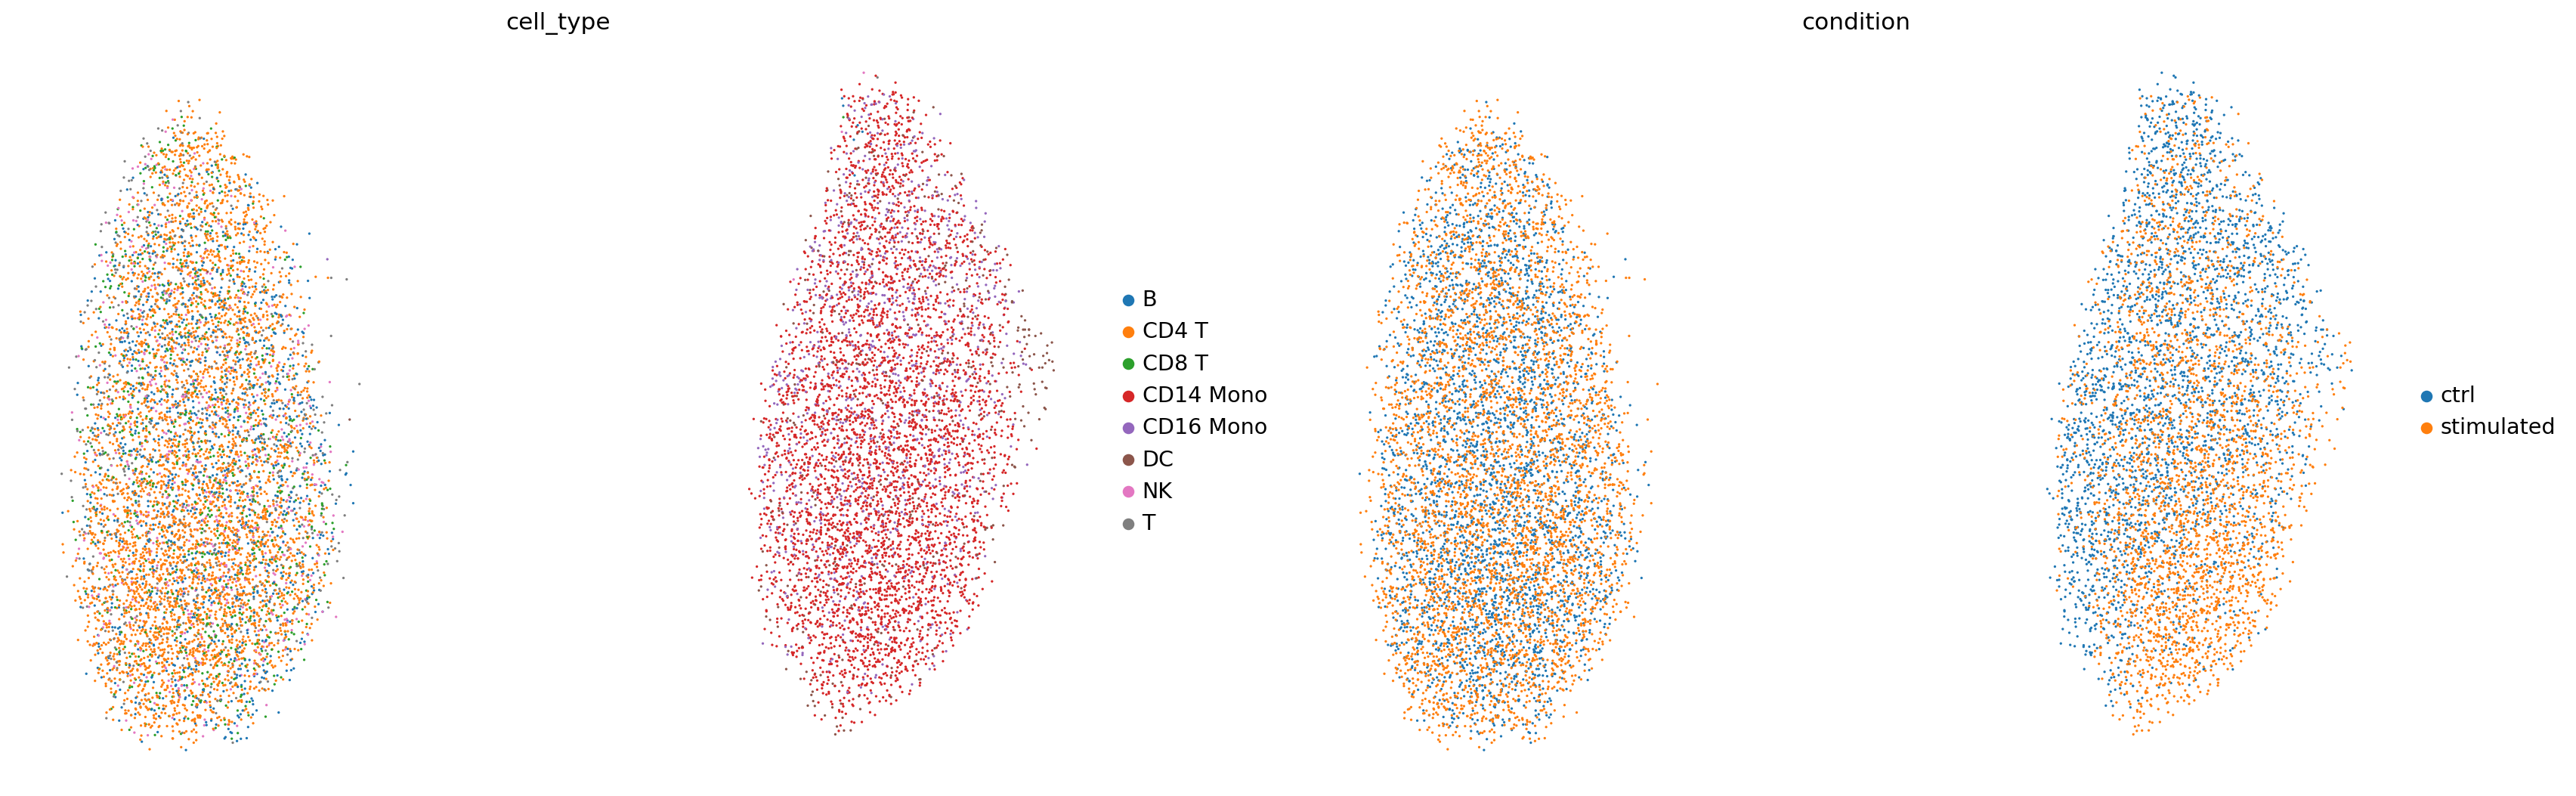

---UMAP for CellDISECT_Z_cell_type---


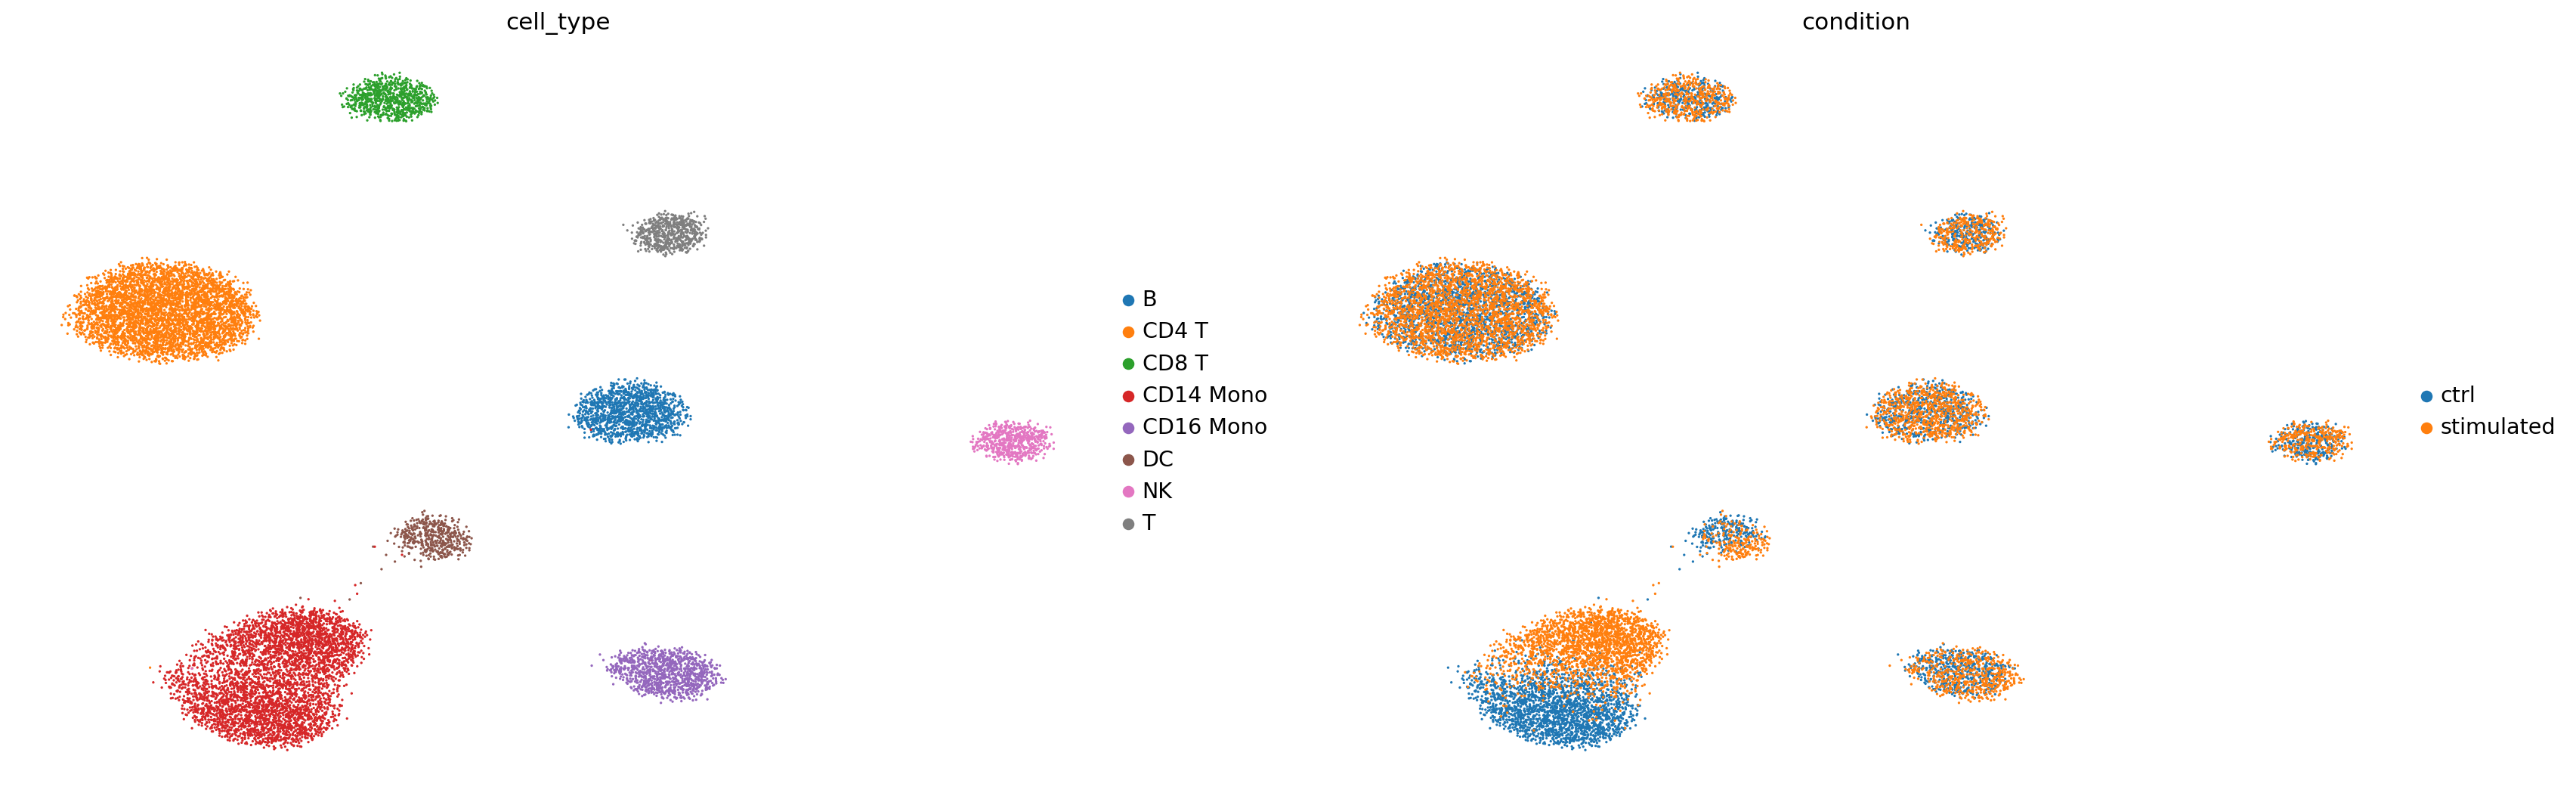

---UMAP for CellDISECT_Z_condition---


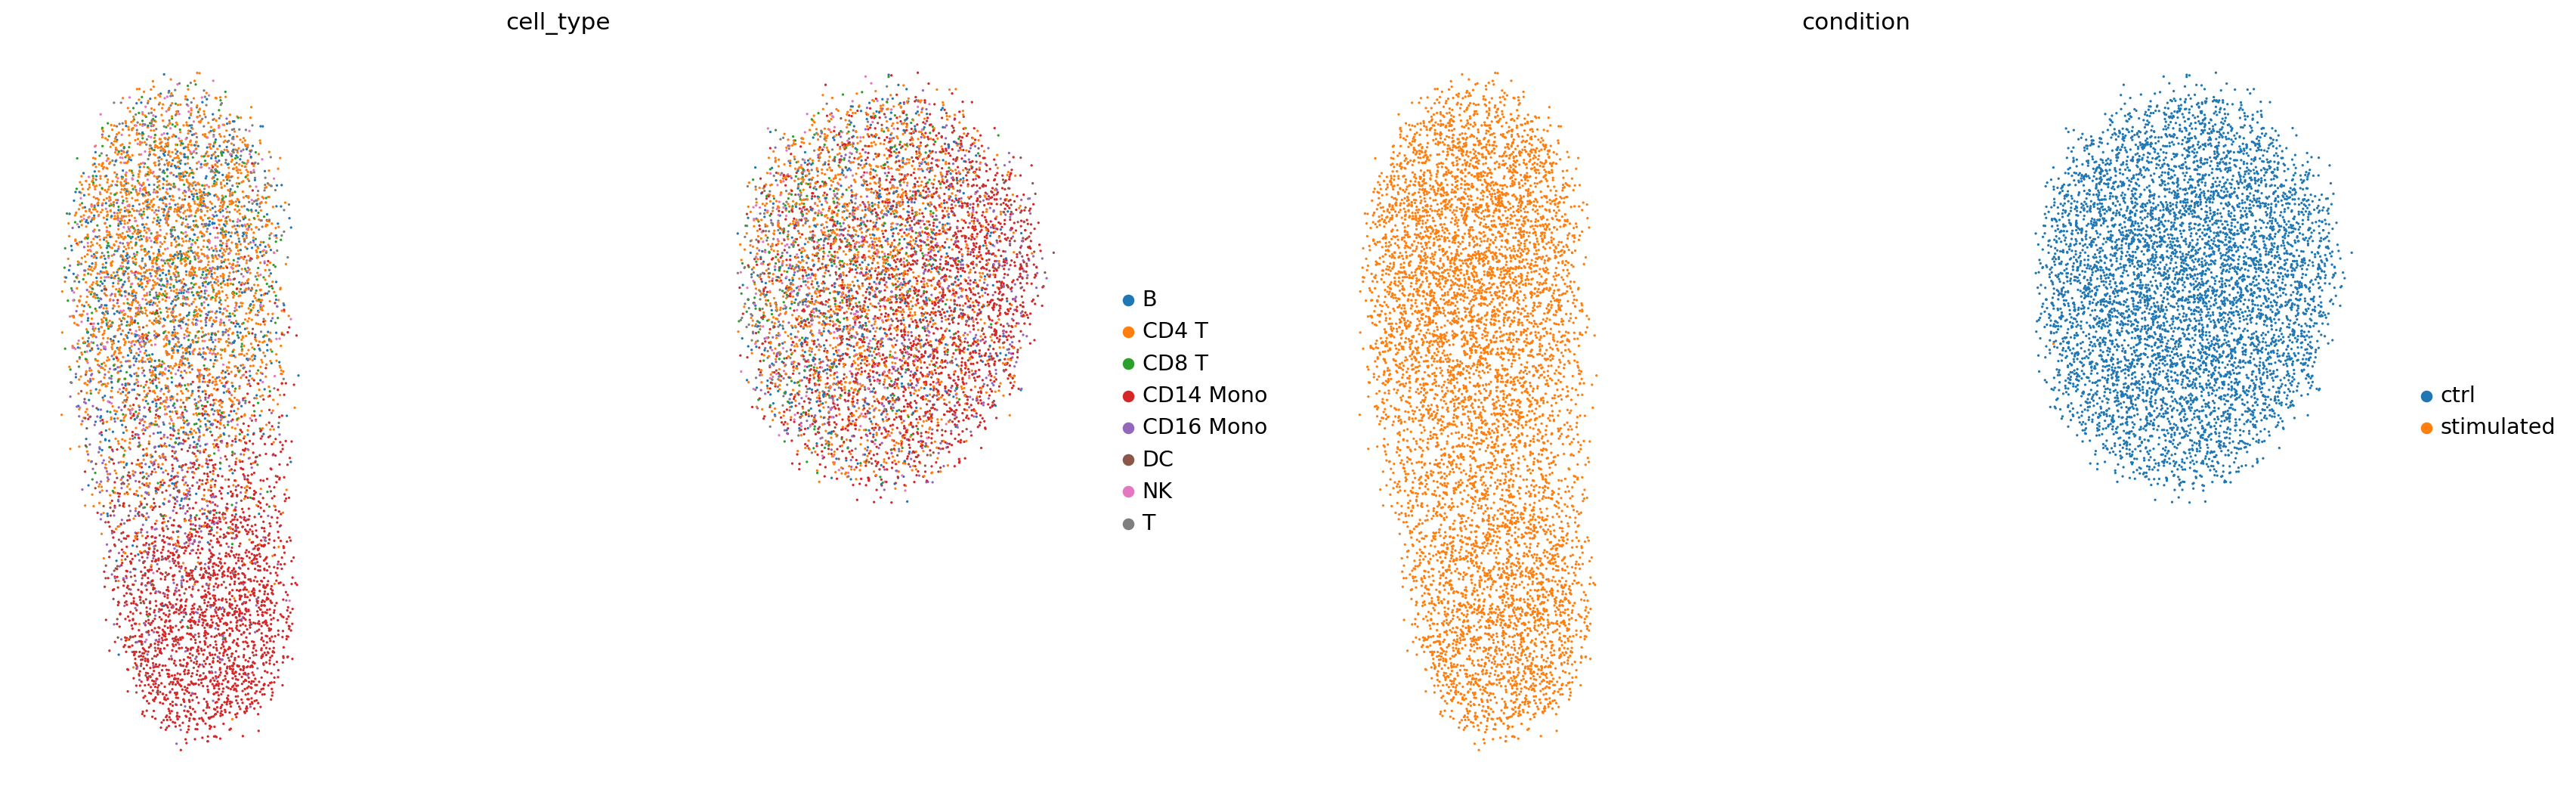

In [18]:
# Plotting Z_i
colors = cats
# colors = cats + ['any_other_obs_key']

for i in range(len(cats) + 1):  # loop over all Z_i
    if i == 0:
        latent_name = f'CellDISECT_Z_{i}'
    else:
        label = cats[i-1]
        latent_name = f'CellDISECT_Z_{label}'


    print(f"---UMAP for {latent_name}---")
    sc.set_figure_params(figsize=(12, 8))
    sc.pl.embedding(
        adata,
        f'{latent_name}_umap',
        color=colors,
        ncols=len(colors),
        frameon=False,
        # legend_loc=None, # Uncomment this line if you want to remove the legend
        # wspace=0.2,
    )


In [12]:
myeloid_lineage = ['CD14 Mono', 'CD16 Mono', 'DC']
lymphoid_lineage = ['CD4 T', 'CD8 T', 'T', 'B', 'NK']

adata.obs.loc[adata.obs['cell_type'].isin(myeloid_lineage), 'lineage'] = 'myeloid'
adata.obs.loc[adata.obs['cell_type'].isin(lymphoid_lineage), 'lineage'] = 'lymphoid'
adata.obs['lineage'].head()

index
AAACATACATTTCC.1     myeloid
AAACATACCAGAAA.1     myeloid
AAACATACCTCGCT.1     myeloid
AAACATACGATGAA.1    lymphoid
AAACATACGGCATT.1     myeloid
Name: lineage, dtype: object

You can see the discovery of underlying effects such as different cell type lineages in Z0

---UMAP for CellDISECT_Z_0---


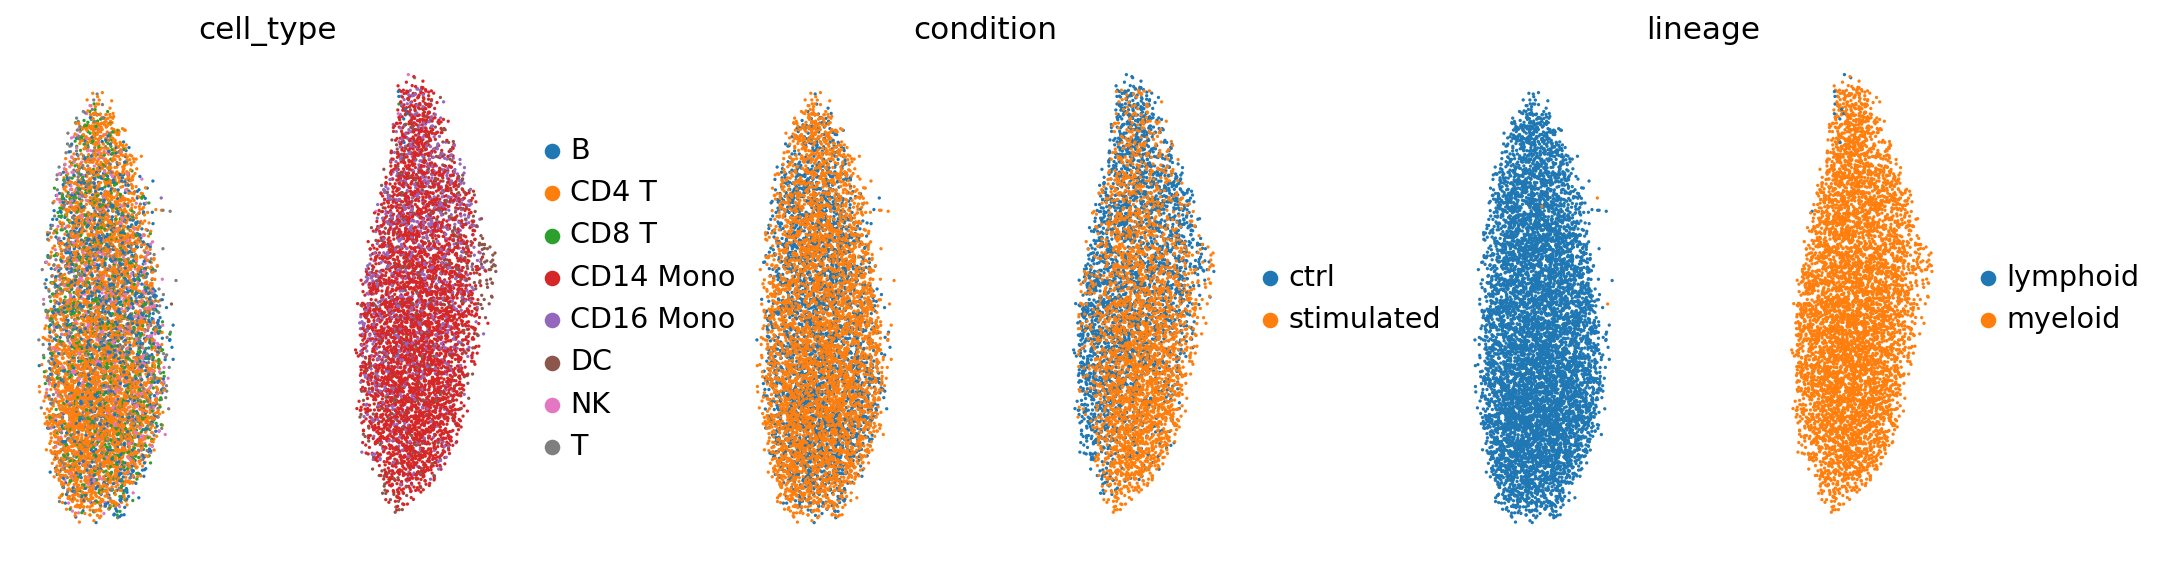

In [20]:
# Plotting Z_i
colors = cats
# colors = cats + ['any_other_obs_key']

i = 0
latent_name = f'CellDISECT_Z_{i}'


print(f"---UMAP for {latent_name}---")
# sc.set_figure_params(figsize=(12, 8))
sc.set_figure_params()
sc.pl.embedding(
    adata,
    f'{latent_name}_umap',
    color=colors + ['lineage'],
    ncols=len(colors)+1,
    frameon=False,
    # legend_loc=None, # Uncomment this line if you want to remove the legend
    wspace=0.3,
)


Let's explore counterfactual predictions

In [13]:
# Getting top Differentially Expressed Genes in each cell type with respect to control vs stimulated condition
adata.X = adata.layers['counts'].copy()
sc.pp.log1p(adata)
adata.obs['cov_condition'] = adata.obs['cell_type'].astype(str) + '_' + adata.obs.condition.astype(str)

groupby='cov_condition'
control_group='ctrl'
key_added="rank_genes_groups"
n_genes=200
return_dict=False
rankby_abs=True
gene_dict = {}
covariate = 'cell_type'
cov_categories = adata.obs[covariate].unique()
for cov_cat in cov_categories:
    print(cov_cat)
    # name of the control group in the groupby obs column
    control_group_cov = "_".join([cov_cat, control_group])
    adata_cov = adata[adata.obs[covariate] == cov_cat]

    sc.tl.rank_genes_groups(
        adata_cov,
        groupby=groupby,
        reference=control_group_cov,
        rankby_abs=rankby_abs,
        n_genes=n_genes,
        use_raw=False,
        method='wilcoxon',
    )

    de_genes_groups = pd.DataFrame(adata_cov.uns["rank_genes_groups"]["names"]).columns

    de_genes = {}
    lfc = {}
    for group in de_genes_groups:
        de_genes[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['names']
        lfc[group] = sc.get.rank_genes_groups_df(adata_cov, group, key='rank_genes_groups', pval_cutoff=0.05, log2fc_min=None, log2fc_max=None)['logfoldchanges']

        lfc_indices = lfc[group].abs().sort_values(ascending=False).index
        de_genes[group] = de_genes[group][lfc_indices].reset_index(drop=True)

        gene_dict[group] = de_genes[group].tolist()

adata.uns[key_added] = gene_dict
adata.X = adata.layers['counts'].copy()

CD14 Mono
CD4 T
T
CD8 T
B
DC
CD16 Mono
NK


We have `CD14 Mono cells` as out of distribution in the model we trained. i.e. the Stimulated T cells have never been seen in the training process.

We want to predict counterfactual expressions of what control T cells would look like, given they were stimulated.

In [22]:
adata[adata.obs['cell_type'] == 'CD14 Mono'].obs['condition'].value_counts()

condition
ctrl          2215
stimulated    2147
Name: count, dtype: int64

In [14]:
x_ctrl, x_true, x_pred = model.predict_counterfactuals(
    adata[adata.obs['cell_type'] == 'CD14 Mono'].copy(), # We want to change T cells
    cov_names = ['condition'], # We want to change their condition
    cov_values = ['ctrl'], # We want to change the control cells
    cov_values_cf = ['stimulated'], # We want to change them to stimulated
    cats = cats,
    n_samples_from_source = None,
    seed = 42,
)
x_ctrl, x_true, x_pred = np.log1p(x_ctrl), np.log1p(x_true), np.log1p(x_pred)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [15]:
x_ctrl.shape, x_true.shape, x_pred.shape

(torch.Size([2215, 5000]), torch.Size([2147, 5000]), torch.Size([2215, 5000]))

In [16]:
deg_list = adata.uns["rank_genes_groups"][f'CD14 Mono_stimulated']

for n_top_deg in [20, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]

    pearson_mean_deg = pearsonr(x_true_deg.mean(0), x_pred_deg.mean(0))
    deltaPearson_mean_deg = pearsonr(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))

    if n_top_deg is not None:
        print(f'Top {n_top_deg} DEGs:')
    else:
        print(f'All highly varaible genes ({adata.shape[1]}):')

    print(f"Pearson correlation: {pearson_mean_deg[0]:.3f}")
    print(f"Delta Pearson correlation: {deltaPearson_mean_deg[0]:.3f}")
    print()

Top 20 DEGs:
Pearson correlation: 0.937
Delta Pearson correlation: 0.931

All highly varaible genes (5000):
Pearson correlation: 0.926
Delta Pearson correlation: 0.818



In [17]:
obs = ['ctrl']*x_ctrl.shape[0] + ['true']*x_true.shape[0] + ['x_CellDISECT']*x_pred.shape[0]
from anndata import AnnData
import torch
results_adata = AnnData(X=torch.concat([x_ctrl, x_true, x_pred]).numpy(),
                        obs={'source': obs},
                        var=adata.var)

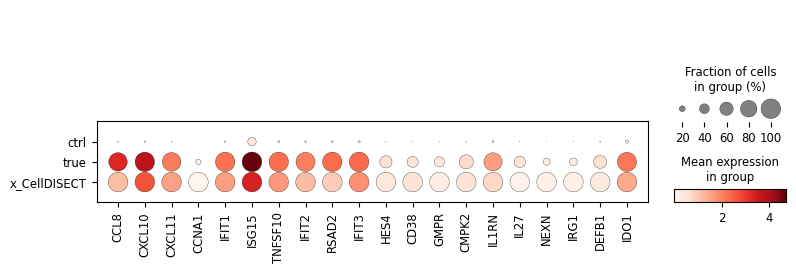

In [39]:
sc.pl.dotplot(results_adata, var_names=deg_list[:20], groupby="source", show=True, swap_axes=False)